In [17]:
from collections import namedtuple
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import matplotlib.cm

import wcs
from wcs import TermData

CONTESTED_MLE = TermData(term=-2, abbrev='Co', translation='Contested')
NO_MLE = TermData(term=-1, abbrev="No", translation="None")

word_counts = {}
term_maps = {}
# langs = [16]
# langs = wcs.ALL_LANGS
langs = [16, 17, 32, 36, 20, 51, 74, 87]
for lang in langs:
    print("building word count and term map for lang ", lang)
    word_counts[lang] = wcs.build_word_count(lang)
    term_maps[lang] = wcs.build_term_map(lang)

building word count and term map for lang  16
building word count and term map for lang  17
building word count and term map for lang  32
building word count and term map for lang  36
building word count and term map for lang  20
building word count and term map for lang  51
building word count and term map for lang  74
building word count and term map for lang  87


In [35]:
def build_simple_mle(word_count, term_map):
    """Returns 
    1. a map of chipnum -> TermData where each
       chipnum is mapped to the majority term for that chip,
       if there is no majority, it is mapped to CONTESTED_MLE
    2. a list of all the MLE terms found i.e. the BCTs
    3. the number of BCTs"""
    mles = {}
    bcts = set()
    
    for chip in wcs.ALL_CHIPS:
        terms = np.argwhere(word_count[:, chip-1] == np.max(word_count[:, chip-1]))
        if len(terms) > 1:
            print("Chip {} was contested".format(chip))
            mles[chip] = CONTESTED_MLE
        else:
            term = terms[0,0]
            mles[chip] = term_map[term+1]
            bcts.add(term_map[term+1])
            
        # print("Row data for chip {}".format(chip))
        # print(word_count[:, chip-1])
        # print("for chip {} got mle = {}".format(chip, mle[chip]))
    
    return mles, list(bcts), len(bcts)

def count_simple_mles(word_count):
    """Returns the number of simple MLEs (BCTs) for the language defined
    by word_count"""
    bcts = set()
    for chip in wcs.ALL_CHIPS:
        terms = np.argwhere(word_count[:, chip-1] == np.max(word_count[:, chip-1]))
        if len(terms) > 1:
            continue
        bcts.add(terms[0,0])
    
    return len(bcts)

def get_BCTs(mles):
    """From the mles return the TermData for each MLE term"""
    bcts = set(mles.values())
    bcts.remove(CONTESTED_MLE)
    return list(bcts)

def all_langs_num_BCTs(word_counts):
    bct_counts = np.zeros((wcs.NUM_LANGS, 1), dtype=int) 
    for lang in wcs.ALL_LANGS:
        word_count = None
        if word_counts == None:
            word_count = wcs.build_word_count(lang)
        else:
            word_count = word_counts[lang]
        bct_counts[lang-1] = count_simple_mles(word_count)
    
    fig, ax = plt.subplots()
    ax.hist(bct_counts, color='xkcd:dark teal', edgecolor='black')
    ax.set_title('BCT counts over all 110 languages')
    fig.set_size_inches((15, 10))
    plt.savefig('output/simple_mle_BCT_histogram.png')
    plt.show()
    
    csv = pd.DataFrame.from_dict(data = {'Language': wcs.ALL_LANGS, 'BCT Count': bct_counts[:,0]})
    csv.to_csv('output/simple_mle_BCT_counts.csv')
    
        
def simple_mle_grid(mles, lang):
    # plot the wcs grid with the mle estimate
    fig, ax = plt.subplots()
    num_cols = 41
    num_rows = len('ABCDEFGHIJ')
    X, Y = np.meshgrid(np.arange(num_cols), np.arange(num_rows))
    Z = np.zeros((num_rows, num_cols), dtype=int)
   
    cmap_list = ['xkcd:pale yellow', 'white', 'xkcd:light pink', 'xkcd:peach', 'xkcd:beige',
                 'xkcd:salmon', 'xkcd:lilac', 'xkcd:orangered',
                 'xkcd:tan', 'xkcd:puke green', 'xkcd:rose',
                 'xkcd:seafoam green', 'xkcd:grass green', 'xkcd:baby blue',
                 'xkcd:olive', 'xkcd:forest green', 'xkcd:deep blue',
                 'xkcd:purple blue', 'xkcd:chocolate', 'xkcd:charcoal', 
                 'xkcd:fuschia', 'xkcd:greyish purple']
    if len(np.unique(mles.values())) > len(cmap_list) - 1:
        print("ERROR: too many cats, cmap does not have enough colors")
    
    # get a set of all mle_terms we will care about
    mle_terms = set([(data.term, data.abbrev) for data in mles.values()])
    mle_terms.add((NO_MLE.term, NO_MLE.abbrev))
    # sort them and store abbreviation labels
    mle_terms = sorted(mle_terms)
    abbrev_labels = [pair[1] for pair in mle_terms]

    # collapse the terms numbers to the range [0, num_mle_terms]
    sorted_terms = [pair[0] for pair in mle_terms]
    collapsed_terms = {}
    for collapsed, term in enumerate(sorted_terms):
        collapsed_terms[term] = collapsed
    collapsed_counts = defaultdict(int)
    
    for row in range(num_rows):
        for col in range(num_cols):
            if (row, col) in wcs.matrix_to_chipnum:
                term = mles[wcs.matrix_to_chipnum[(row, col)]].term
                Z[row, col] = collapsed_terms[term]
                collapsed_counts[collapsed_terms[term]] += 1
            else:
                Z[row, col] = collapsed_terms[NO_MLE.term]
                collapsed_counts[collapsed_terms[NO_MLE.term]] += 1
                # print("using no_mle_val for col {} and row {}".format(col, row))

    
    cmap = ListedColormap(cmap_list[:len(abbrev_labels)])
    mesh = ax.pcolormesh(X, Y, Z, shading='auto', edgecolors='black', cmap=cmap)
    # pcolormesh needs to have data flipped
    ax.invert_yaxis()
    
    # colorbar and ticks alignment
    cbar = fig.colorbar(matplotlib.cm.ScalarMappable(cmap=cmap), ax=ax)
    tick_spacing = 1.0 / len(abbrev_labels)
    ticks = ticker.FixedLocator(np.arange(tick_spacing/2.0, 1.0, tick_spacing))
    cbar.set_ticks(ticks)
    tick_texts = cbar.ax.set_yticklabels(abbrev_labels)
    # tick_texts[0].set_verticalalignment('top')
    # tick_texts[-1].set_verticalalignment('bottom')
    cbar.ax.tick_params(length=0) # remove the tick marks

    # setup grid labels and title
    ax.set_title('MLE Categories for Language {}'.format(lang))
    ax.set_xticks(np.arange(num_cols))
    ax.set_yticks(np.arange(num_rows))
    ax.set_xticklabels([str(i) for i in range(41)])
    ax.set_yticklabels([c for c in 'ABCDEFGHIJ'])
    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

    fig.set_size_inches((36, 8))
    # plt.show()
    plt.savefig('output/lang{}_simple_mle_grid.png'.format(lang))
    
# heatmap plotting function following the guide in the matplotlib documentation
def plot_heatmap(data, ax):
    im = ax.pcolormesh(data, edgecolors='black', cmap = 'hot_r')
    # pcolormesh needs to have data flipped
    ax.invert_yaxis()

    ax.set_xticks(np.arange(0.5, data.shape[1], 1))
    ax.set_yticks(np.arange(0.5, data.shape[0], 1))

    ax.set_xticklabels([str(i) for i in range(41)])
    ax.set_yticklabels([c for c in 'ABCDEFGHIJ'])

    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

    return im

# plot heatmaps for the bcts
def bct_heatmaps(language, word_count, bcts):
    # normalization for colormaps
    word_count_max = np.max(word_count)
    num_categories = len(bcts)
    num_rows = num_categories
    num_cols = 1
    # if num_categories > 4:
    #     num_cols = 2
    #     num_rows = 4
    # if num_categories > 8:
    #     print('ERROR: too many categories')
    
    fig, ax = plt.subplots(num_categories, 1)
    for bid, bct in enumerate(bcts):
        data = np.zeros((10, 41))
        data[0, 40] = word_count_max
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                if (i, j) in wcs.matrix_to_chipnum:
                    data[i, j] = word_count[bct.term-1, wcs.matrix_to_chipnum[(i, j)] - 1]
        
        im = plot_heatmap(data, ax[bid])
        ax[bid].set_title('Term: {}, abbrev {}, translation {}'.format(bct.term, bct.abbrev, bct.translation))
    
    fig.set_size_inches((32, 8*num_categories))
    plt.savefig('output/lang{}_simple_mle_bct_heatmaps.png'.format(language))


Making grid and heatmaps for lang  16
Chip 26 was contested
Chip 63 was contested
Chip 105 was contested
Chip 138 was contested
Chip 215 was contested
Making grid and heatmaps for lang  17
Chip 3 was contested
Chip 59 was contested
Chip 60 was contested
Chip 154 was contested
Chip 290 was contested
Making grid and heatmaps for lang  32
Chip 63 was contested
Chip 74 was contested
Chip 84 was contested
Chip 250 was contested
Chip 263 was contested
Chip 303 was contested
Making grid and heatmaps for lang  36
Chip 197 was contested
Chip 208 was contested
Making grid and heatmaps for lang  20
Chip 29 was contested
Chip 67 was contested
Chip 78 was contested
Chip 99 was contested
Chip 202 was contested
Chip 232 was contested
Chip 249 was contested
Chip 268 was contested
Chip 269 was contested
Making grid and heatmaps for lang  51
Chip 9 was contested
Chip 104 was contested
Chip 143 was contested
Chip 160 was contested
Chip 165 was contested
Chip 184 was contested
Chip 233 was contested
Chip 

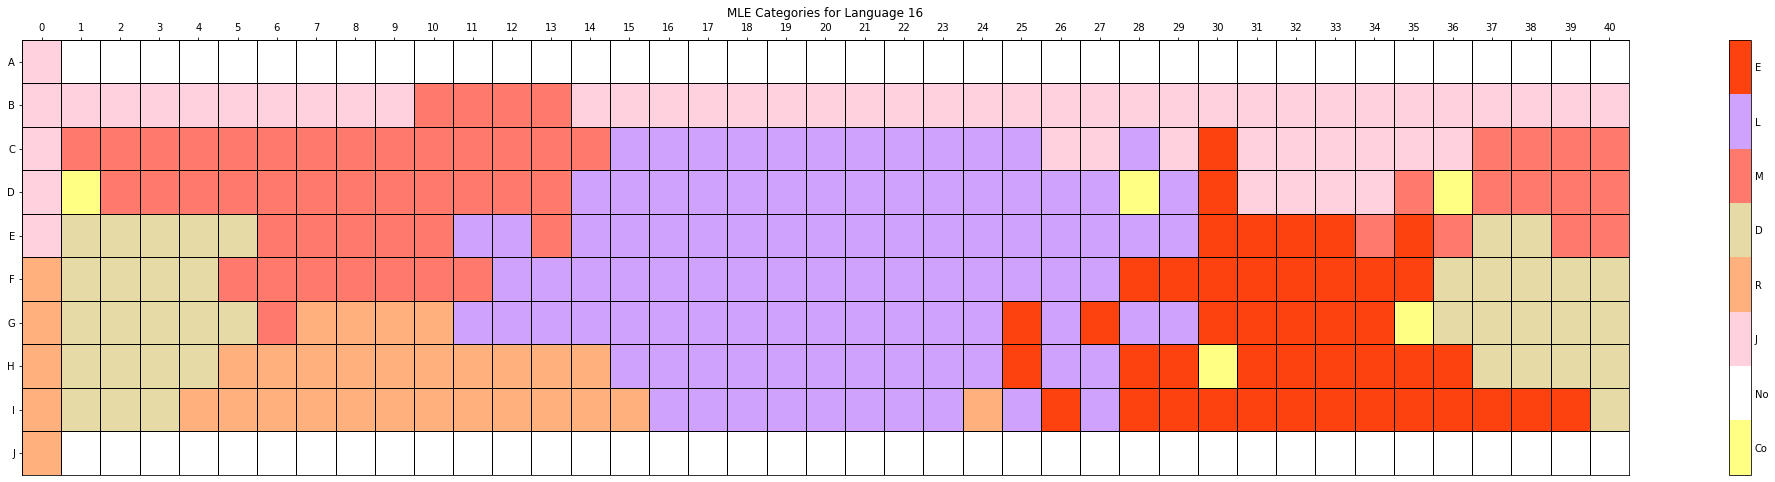

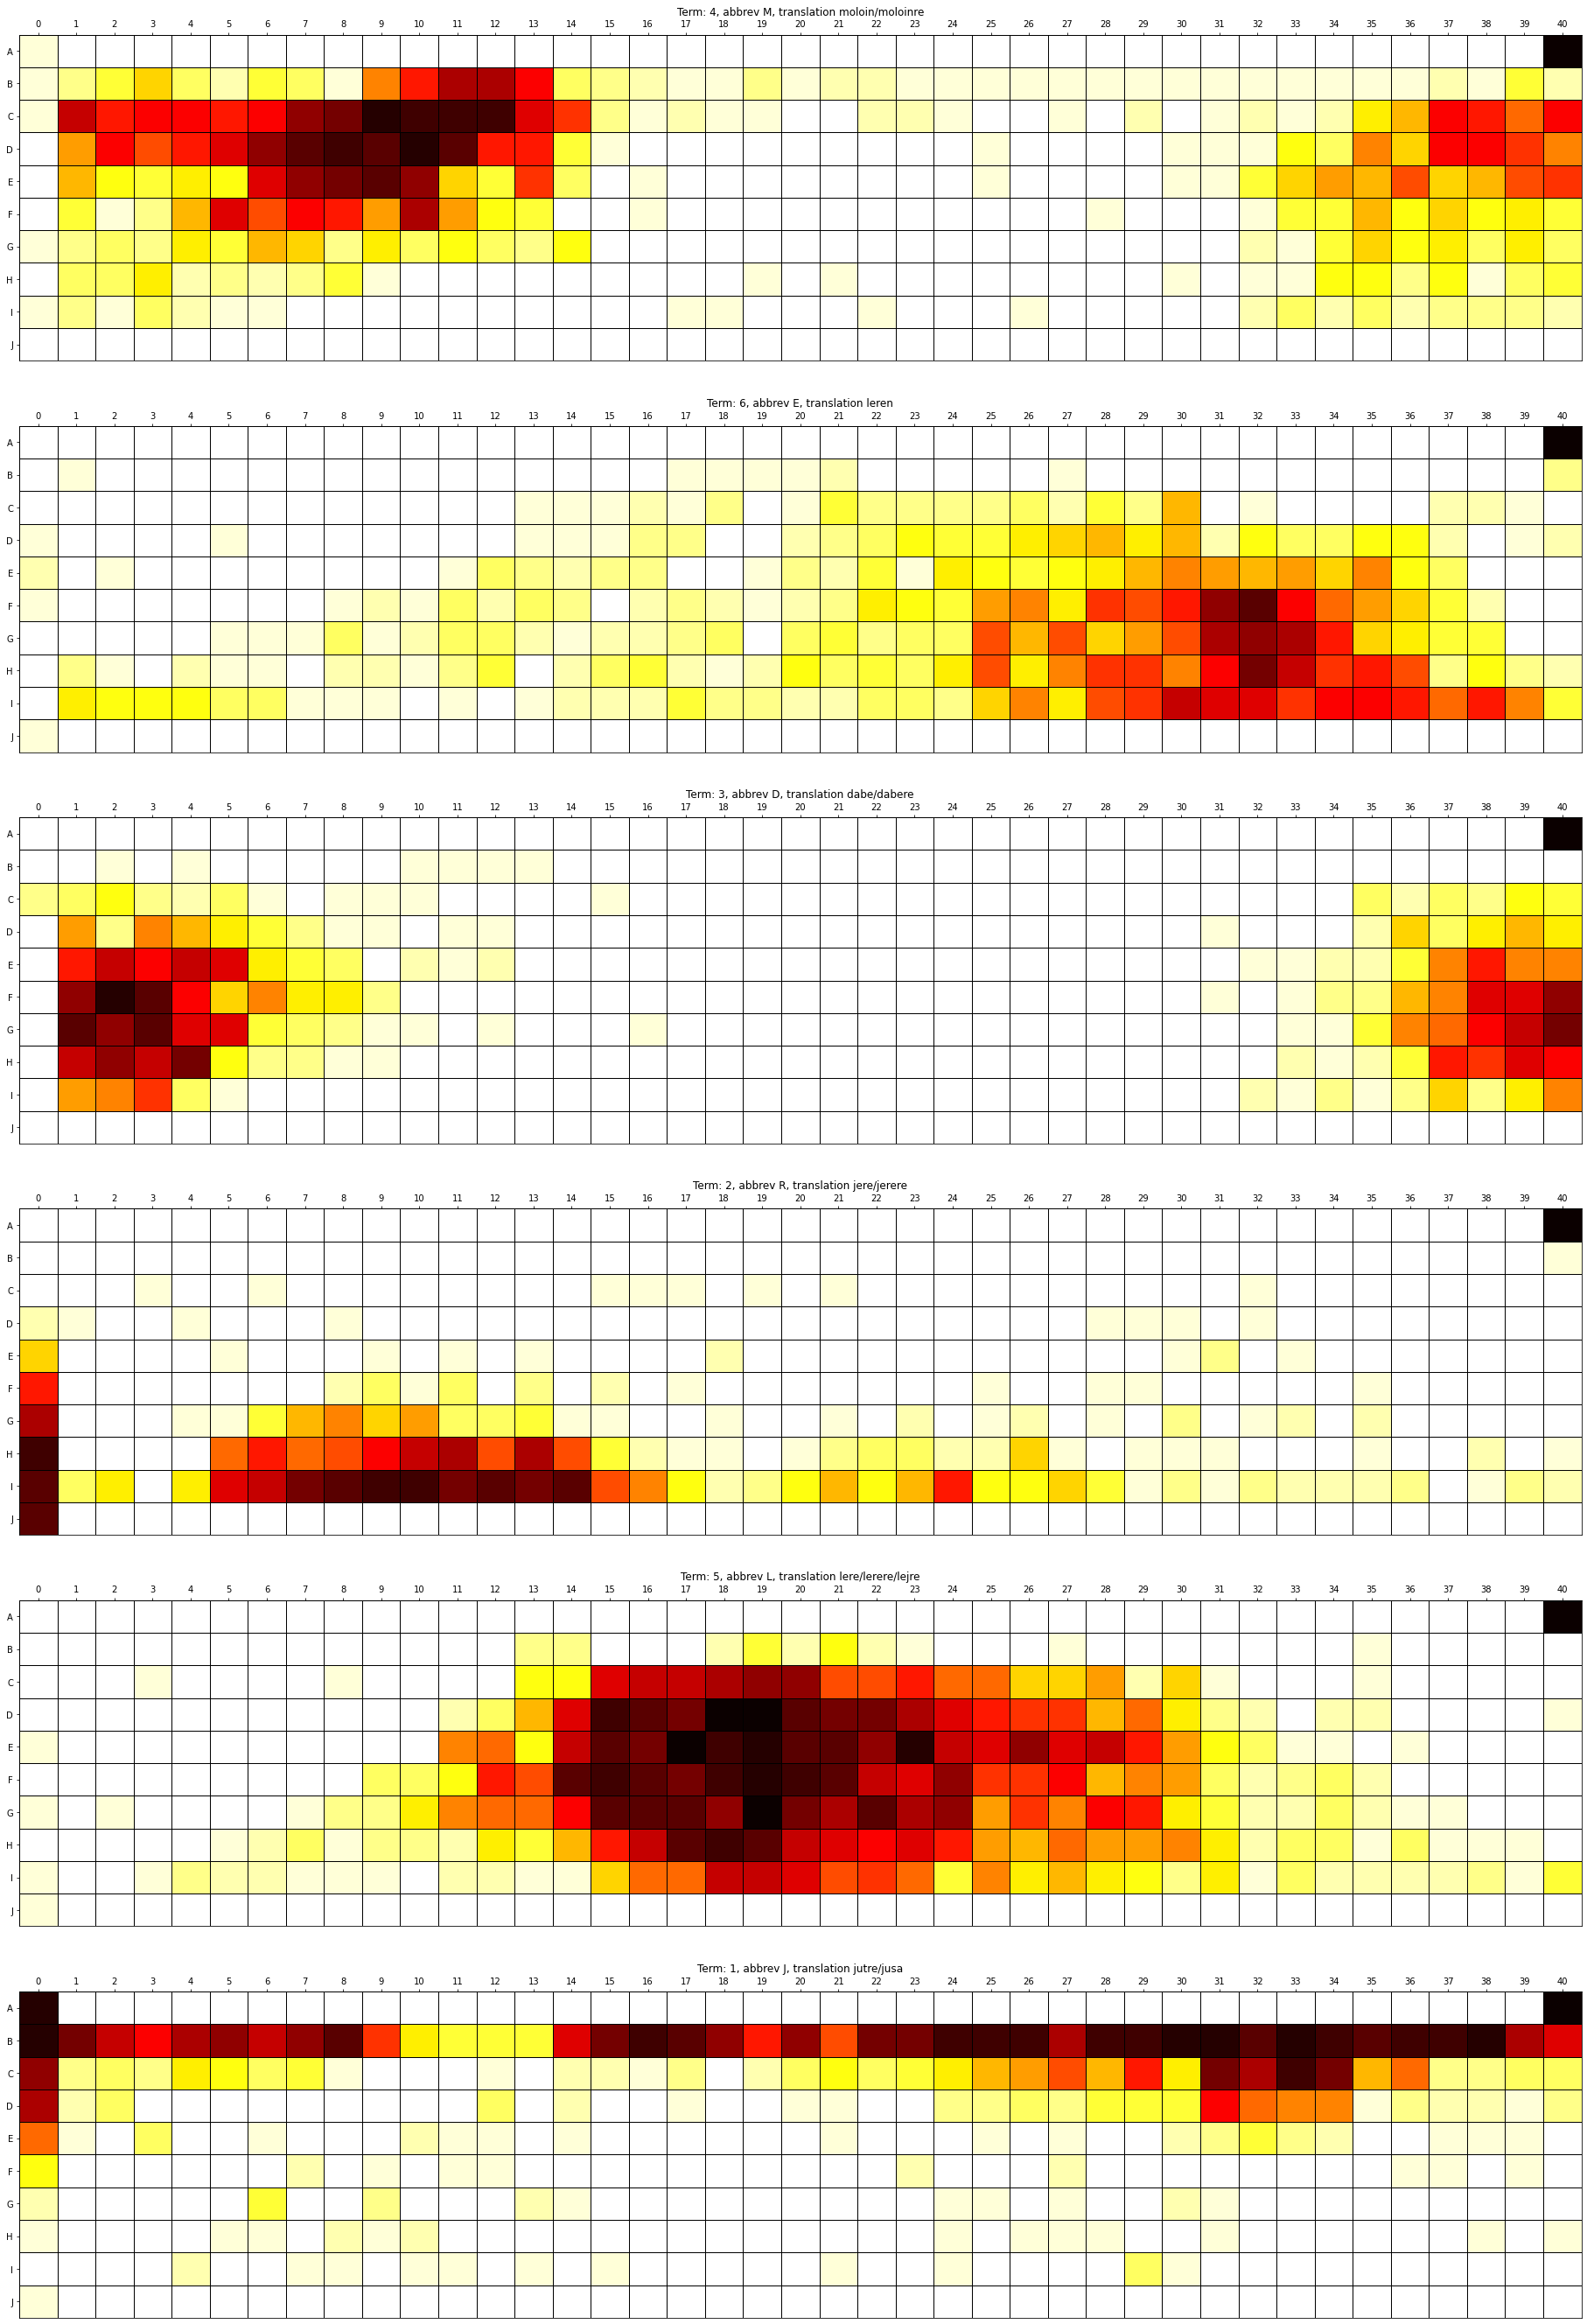

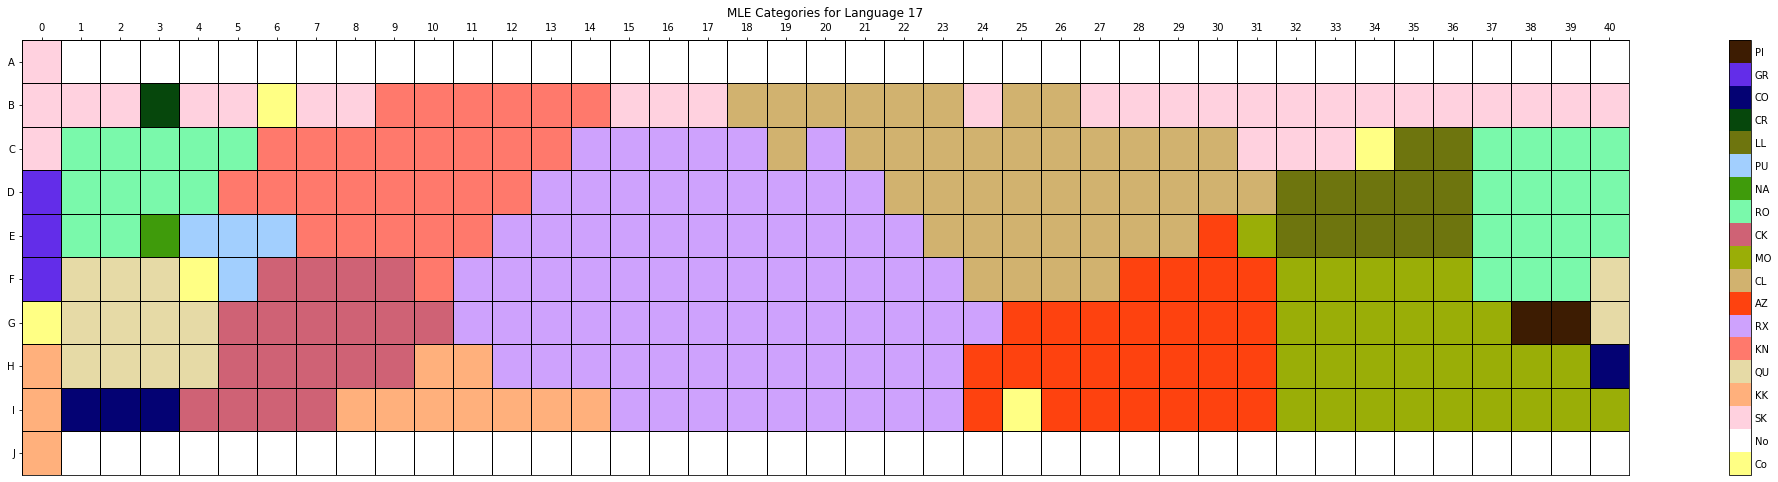

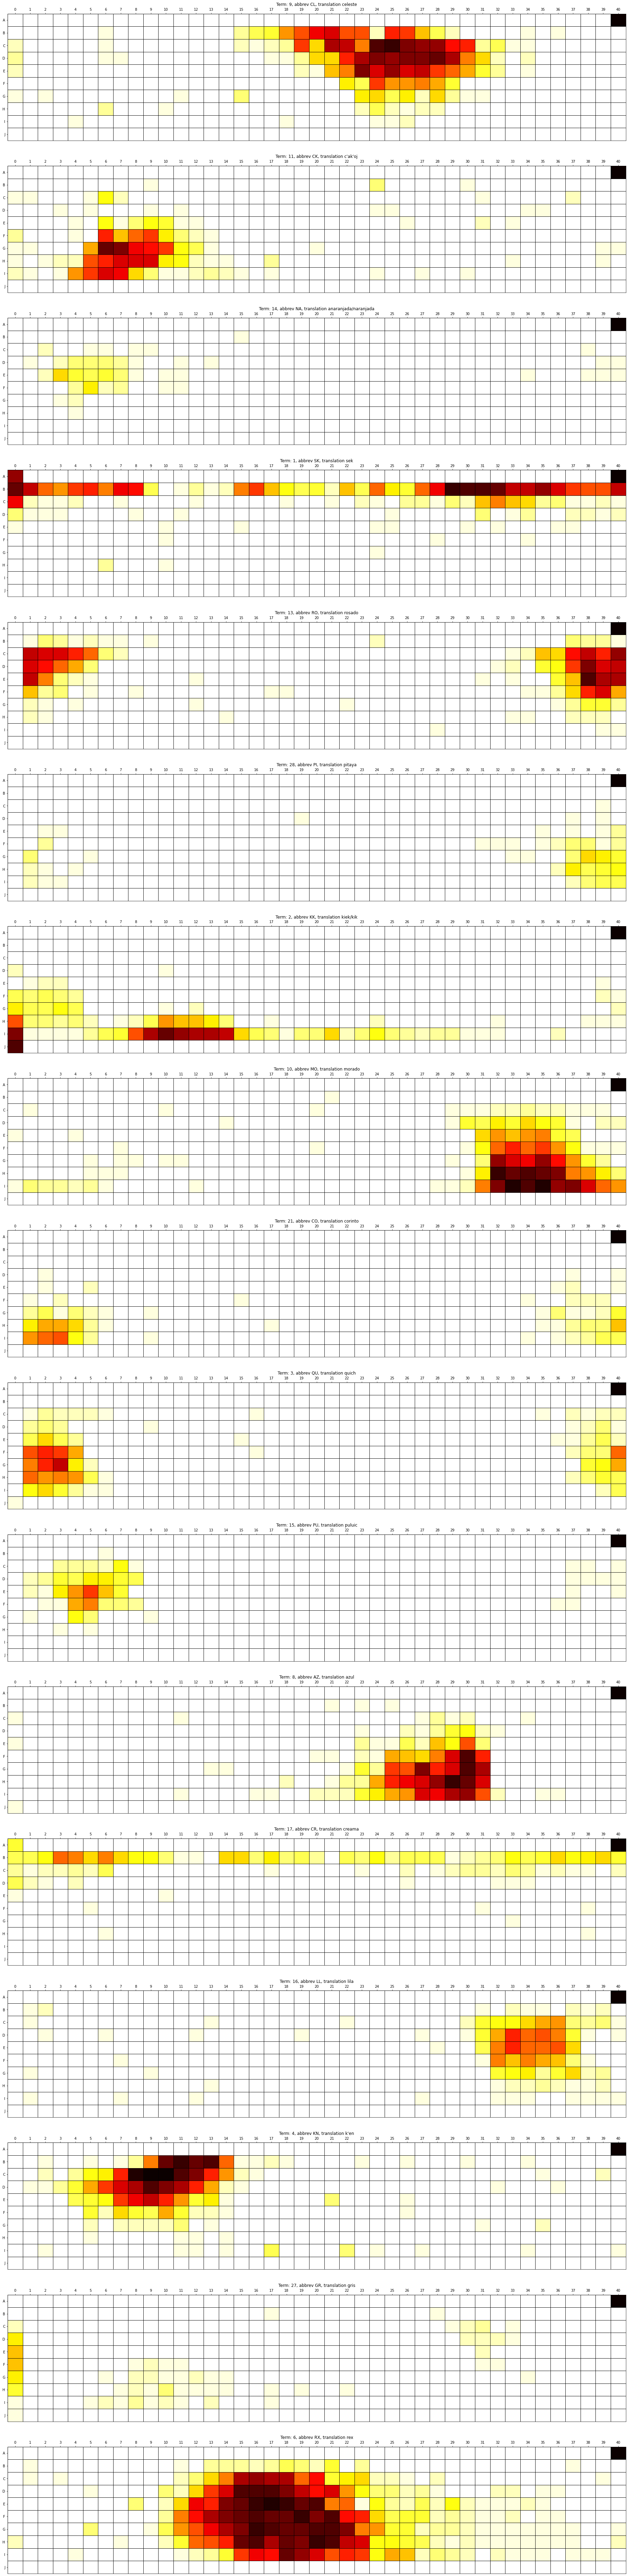

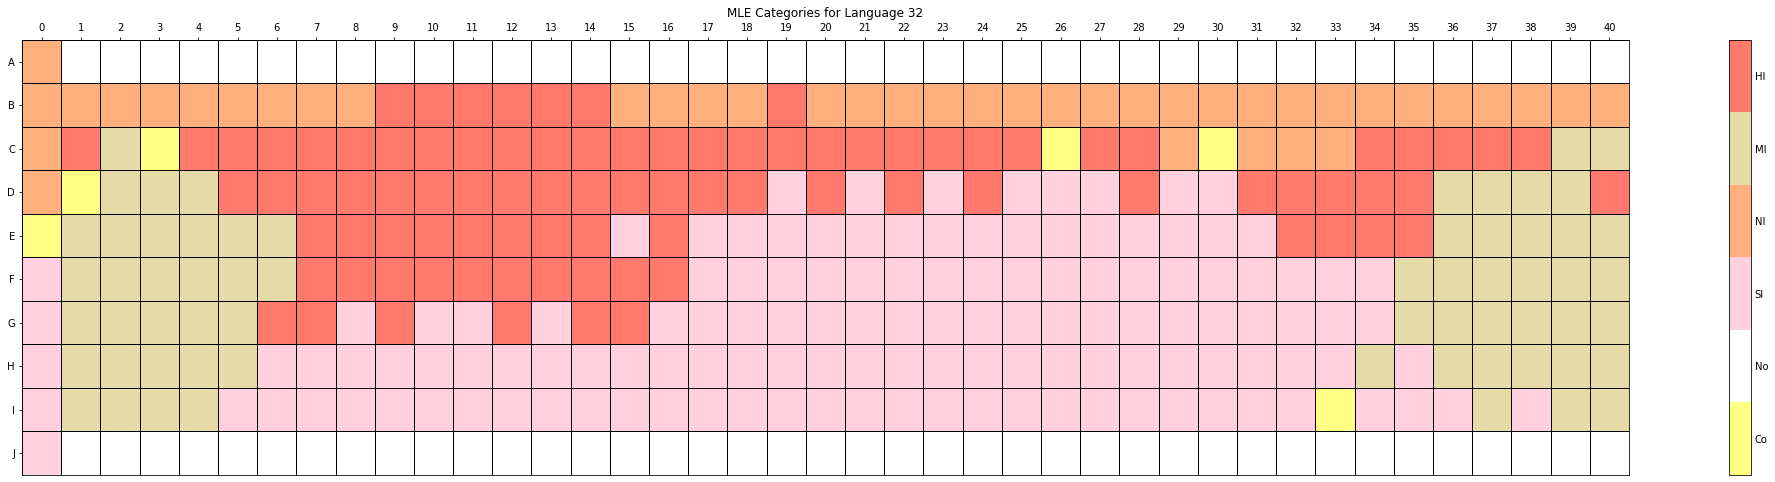

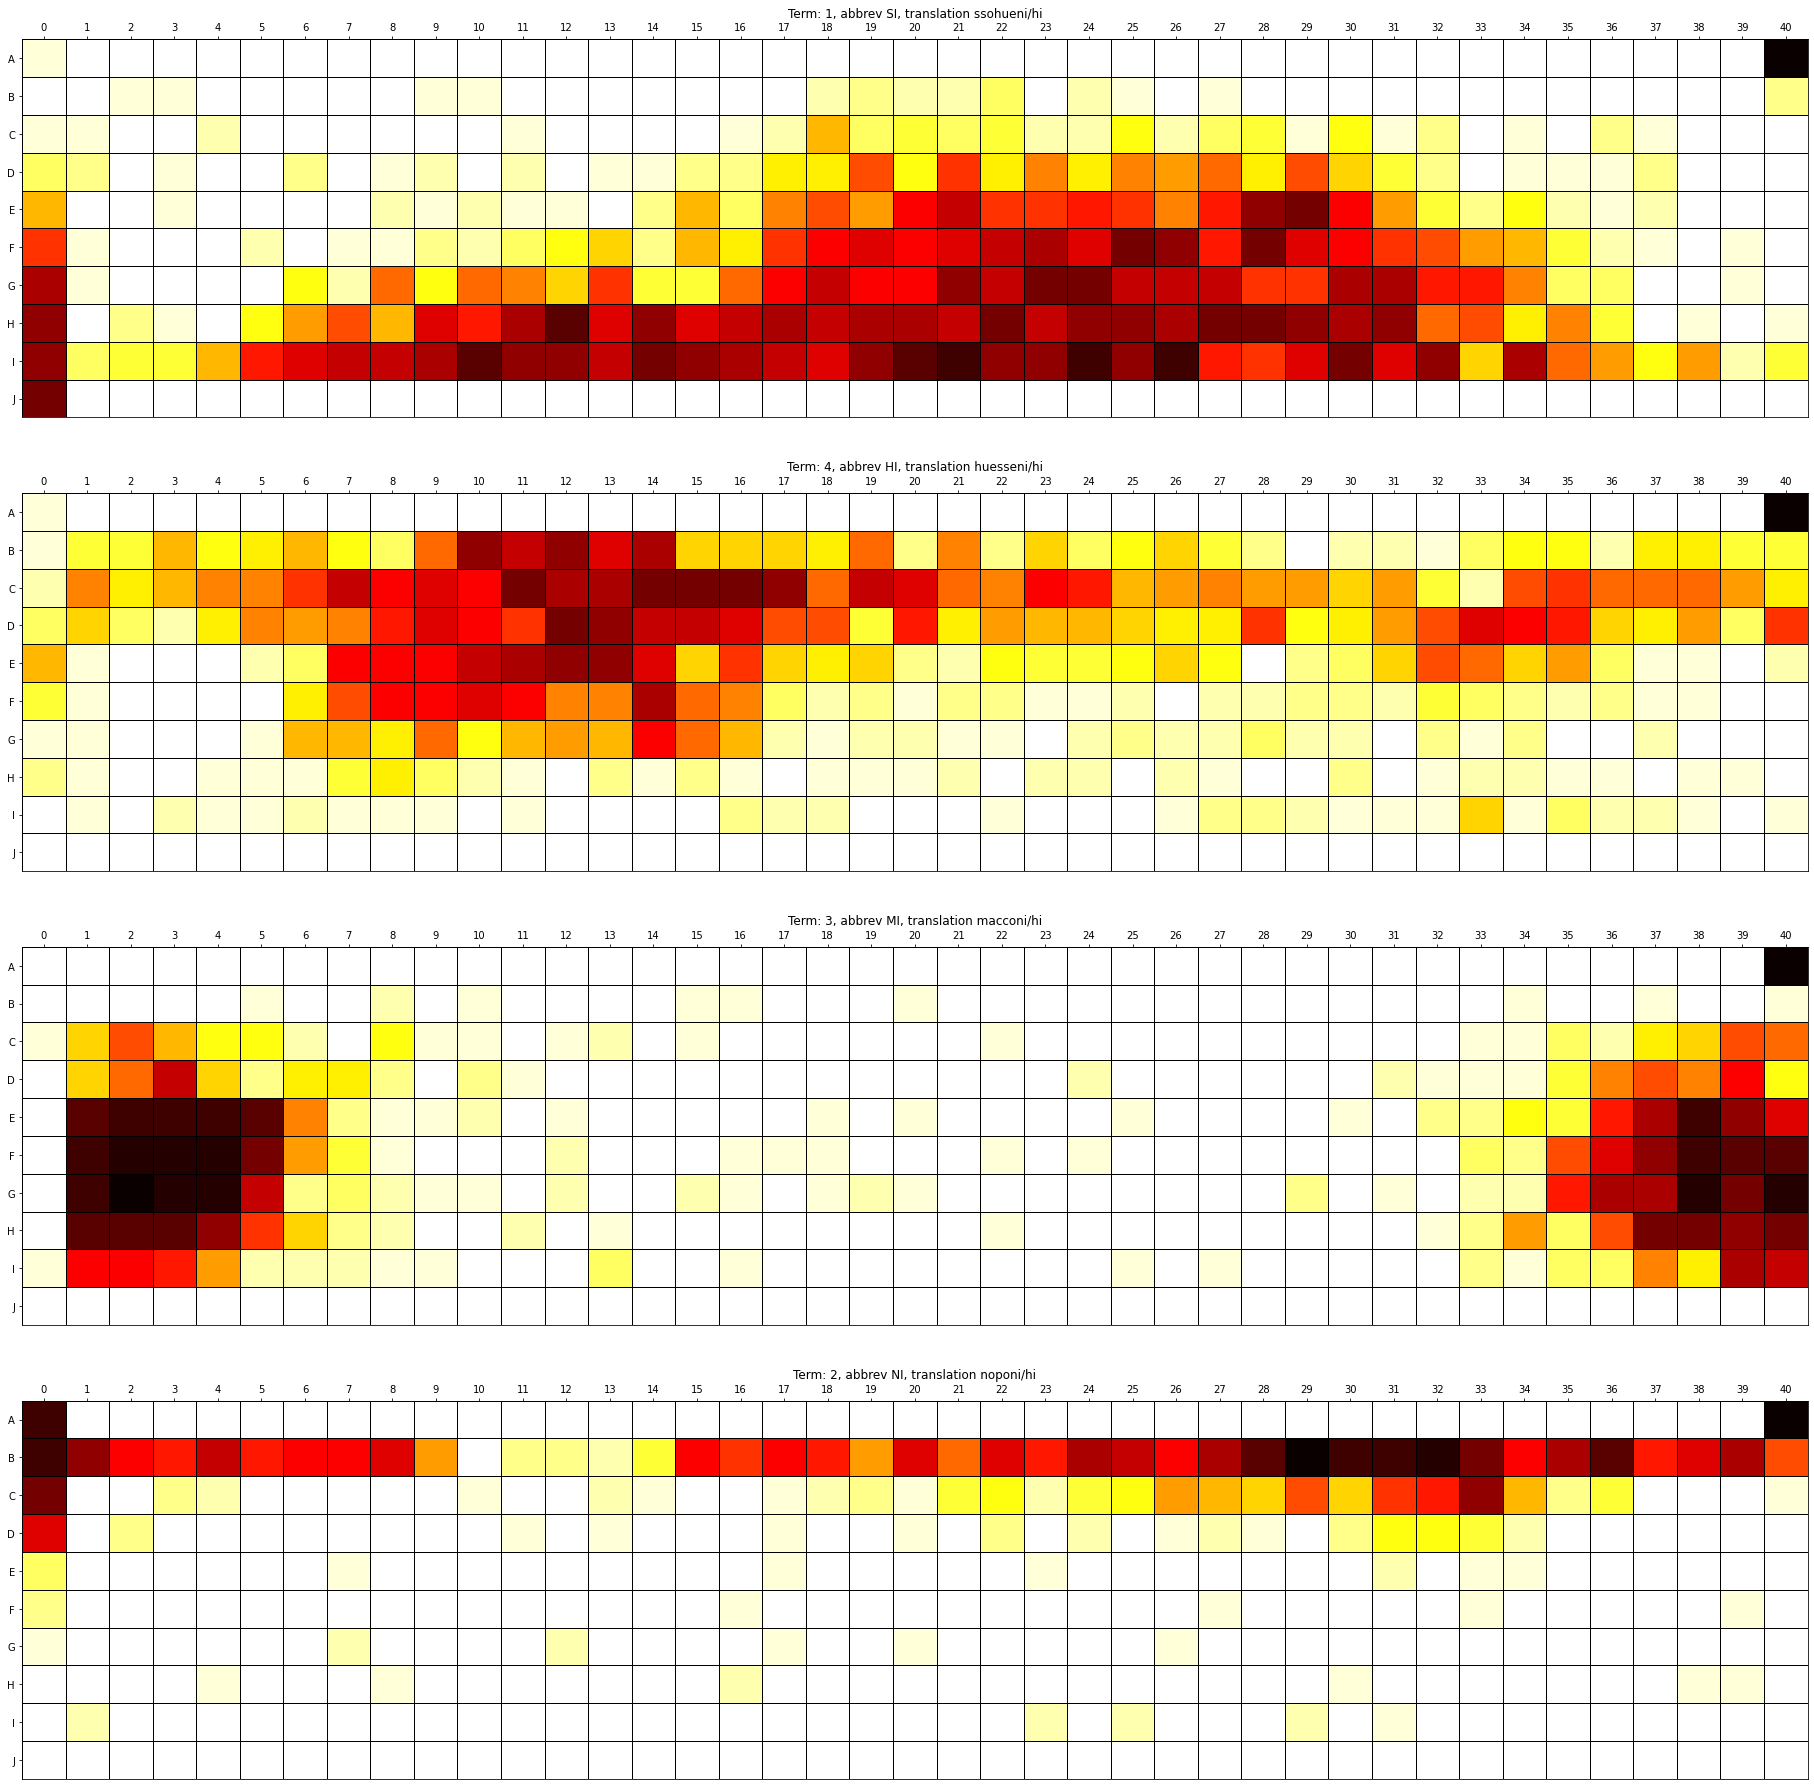

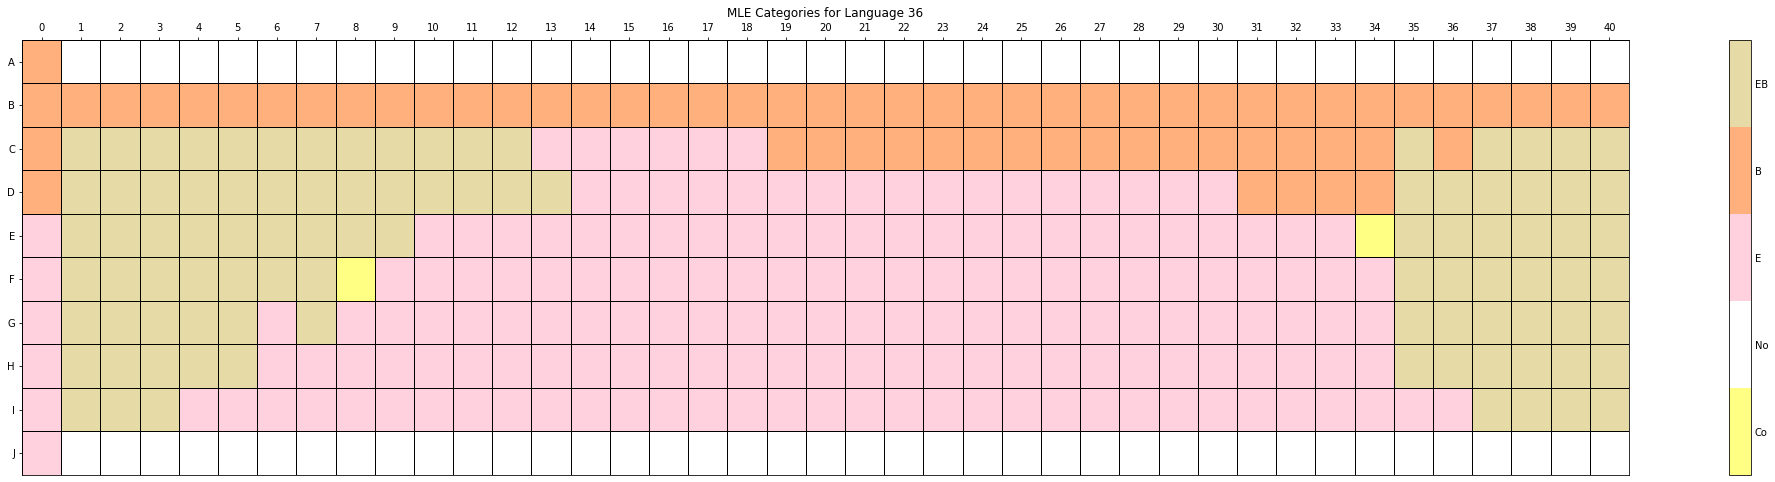

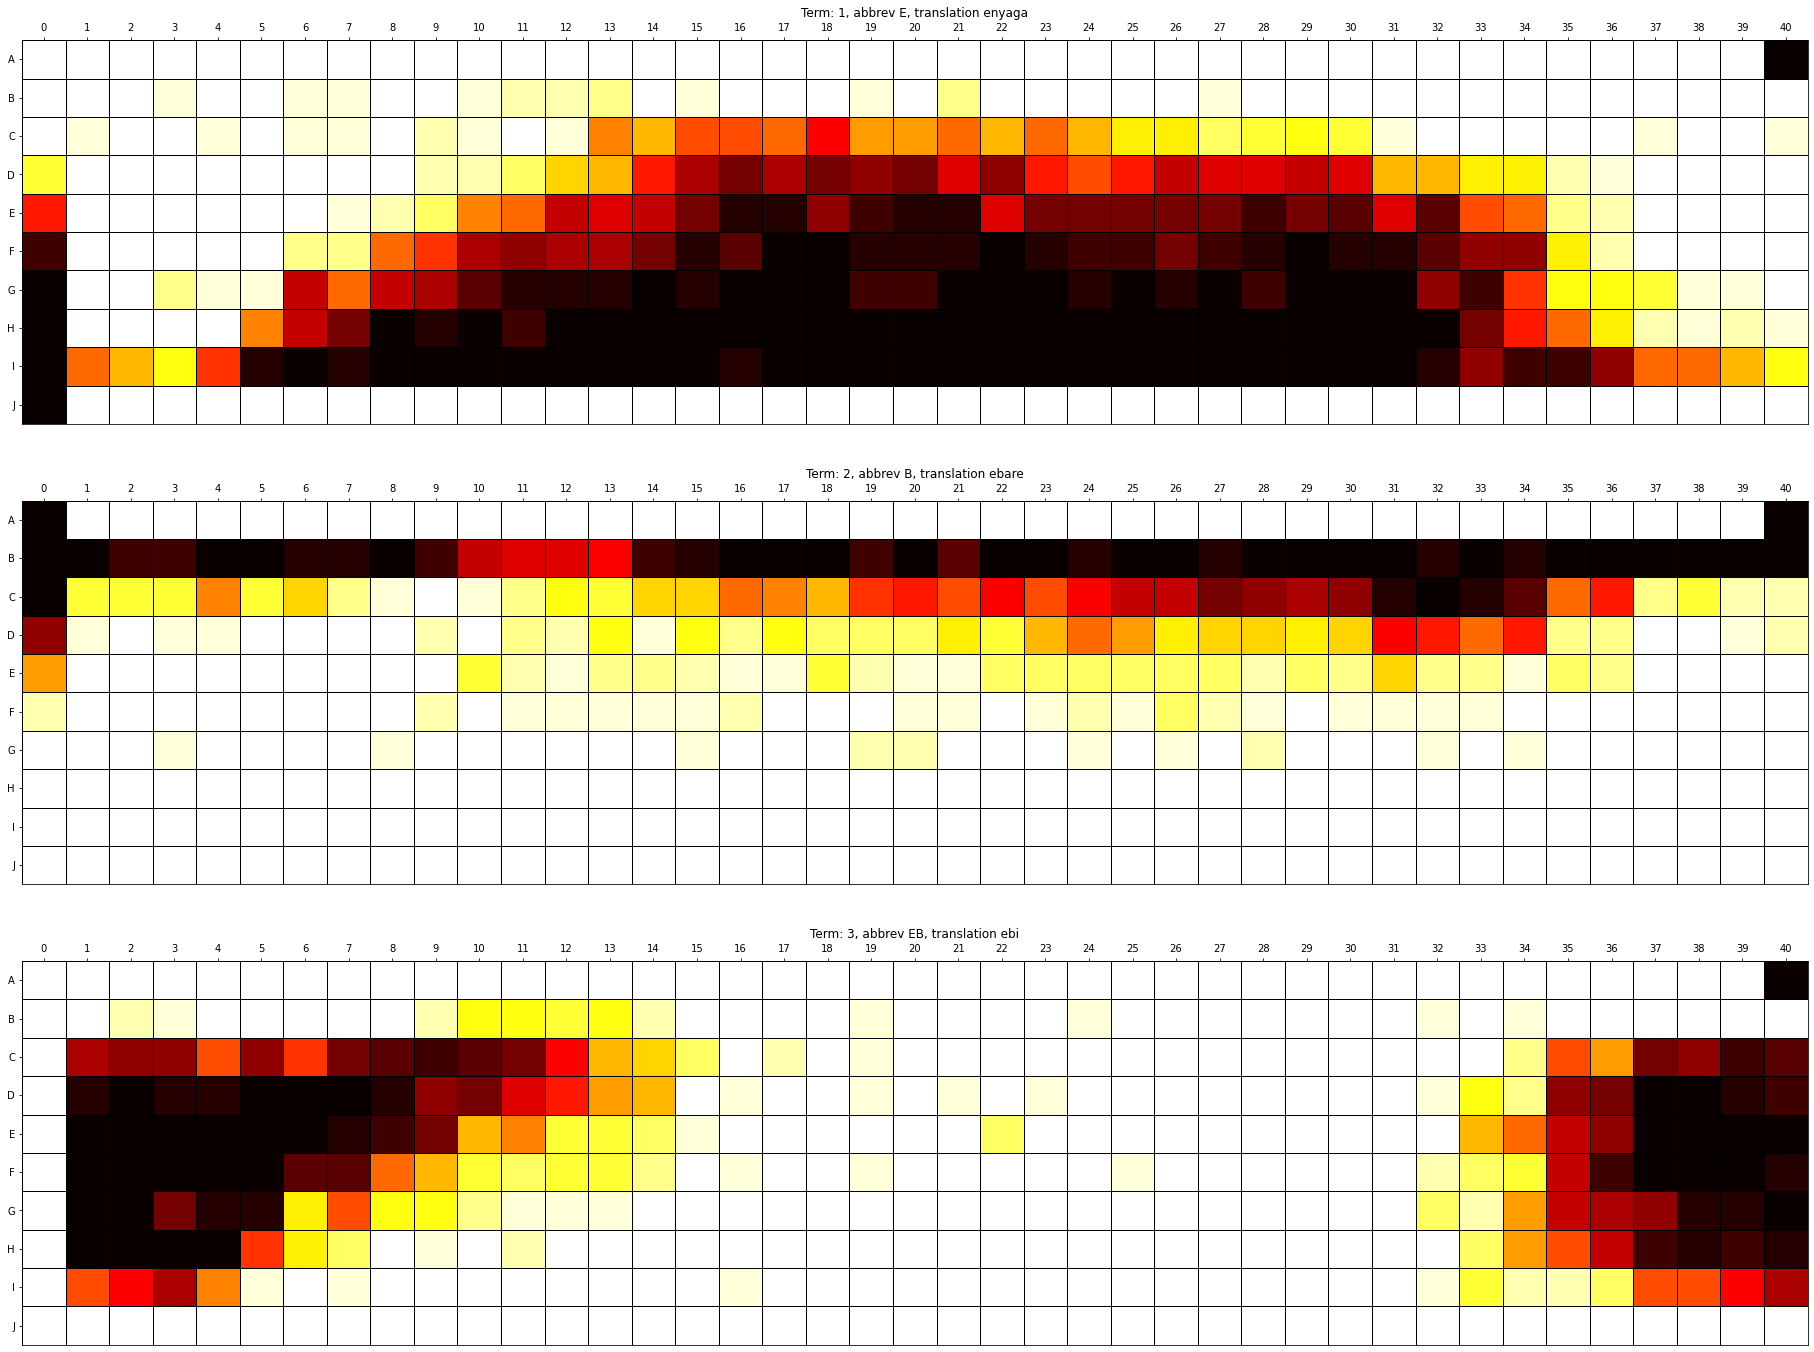

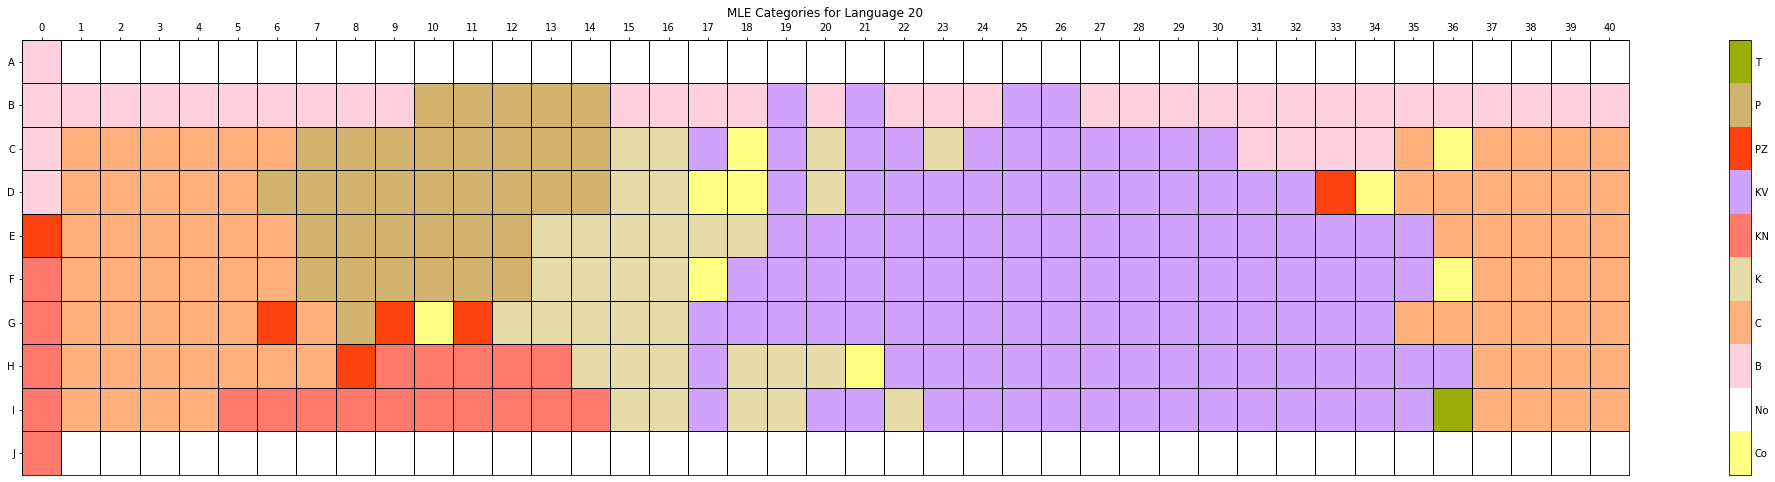

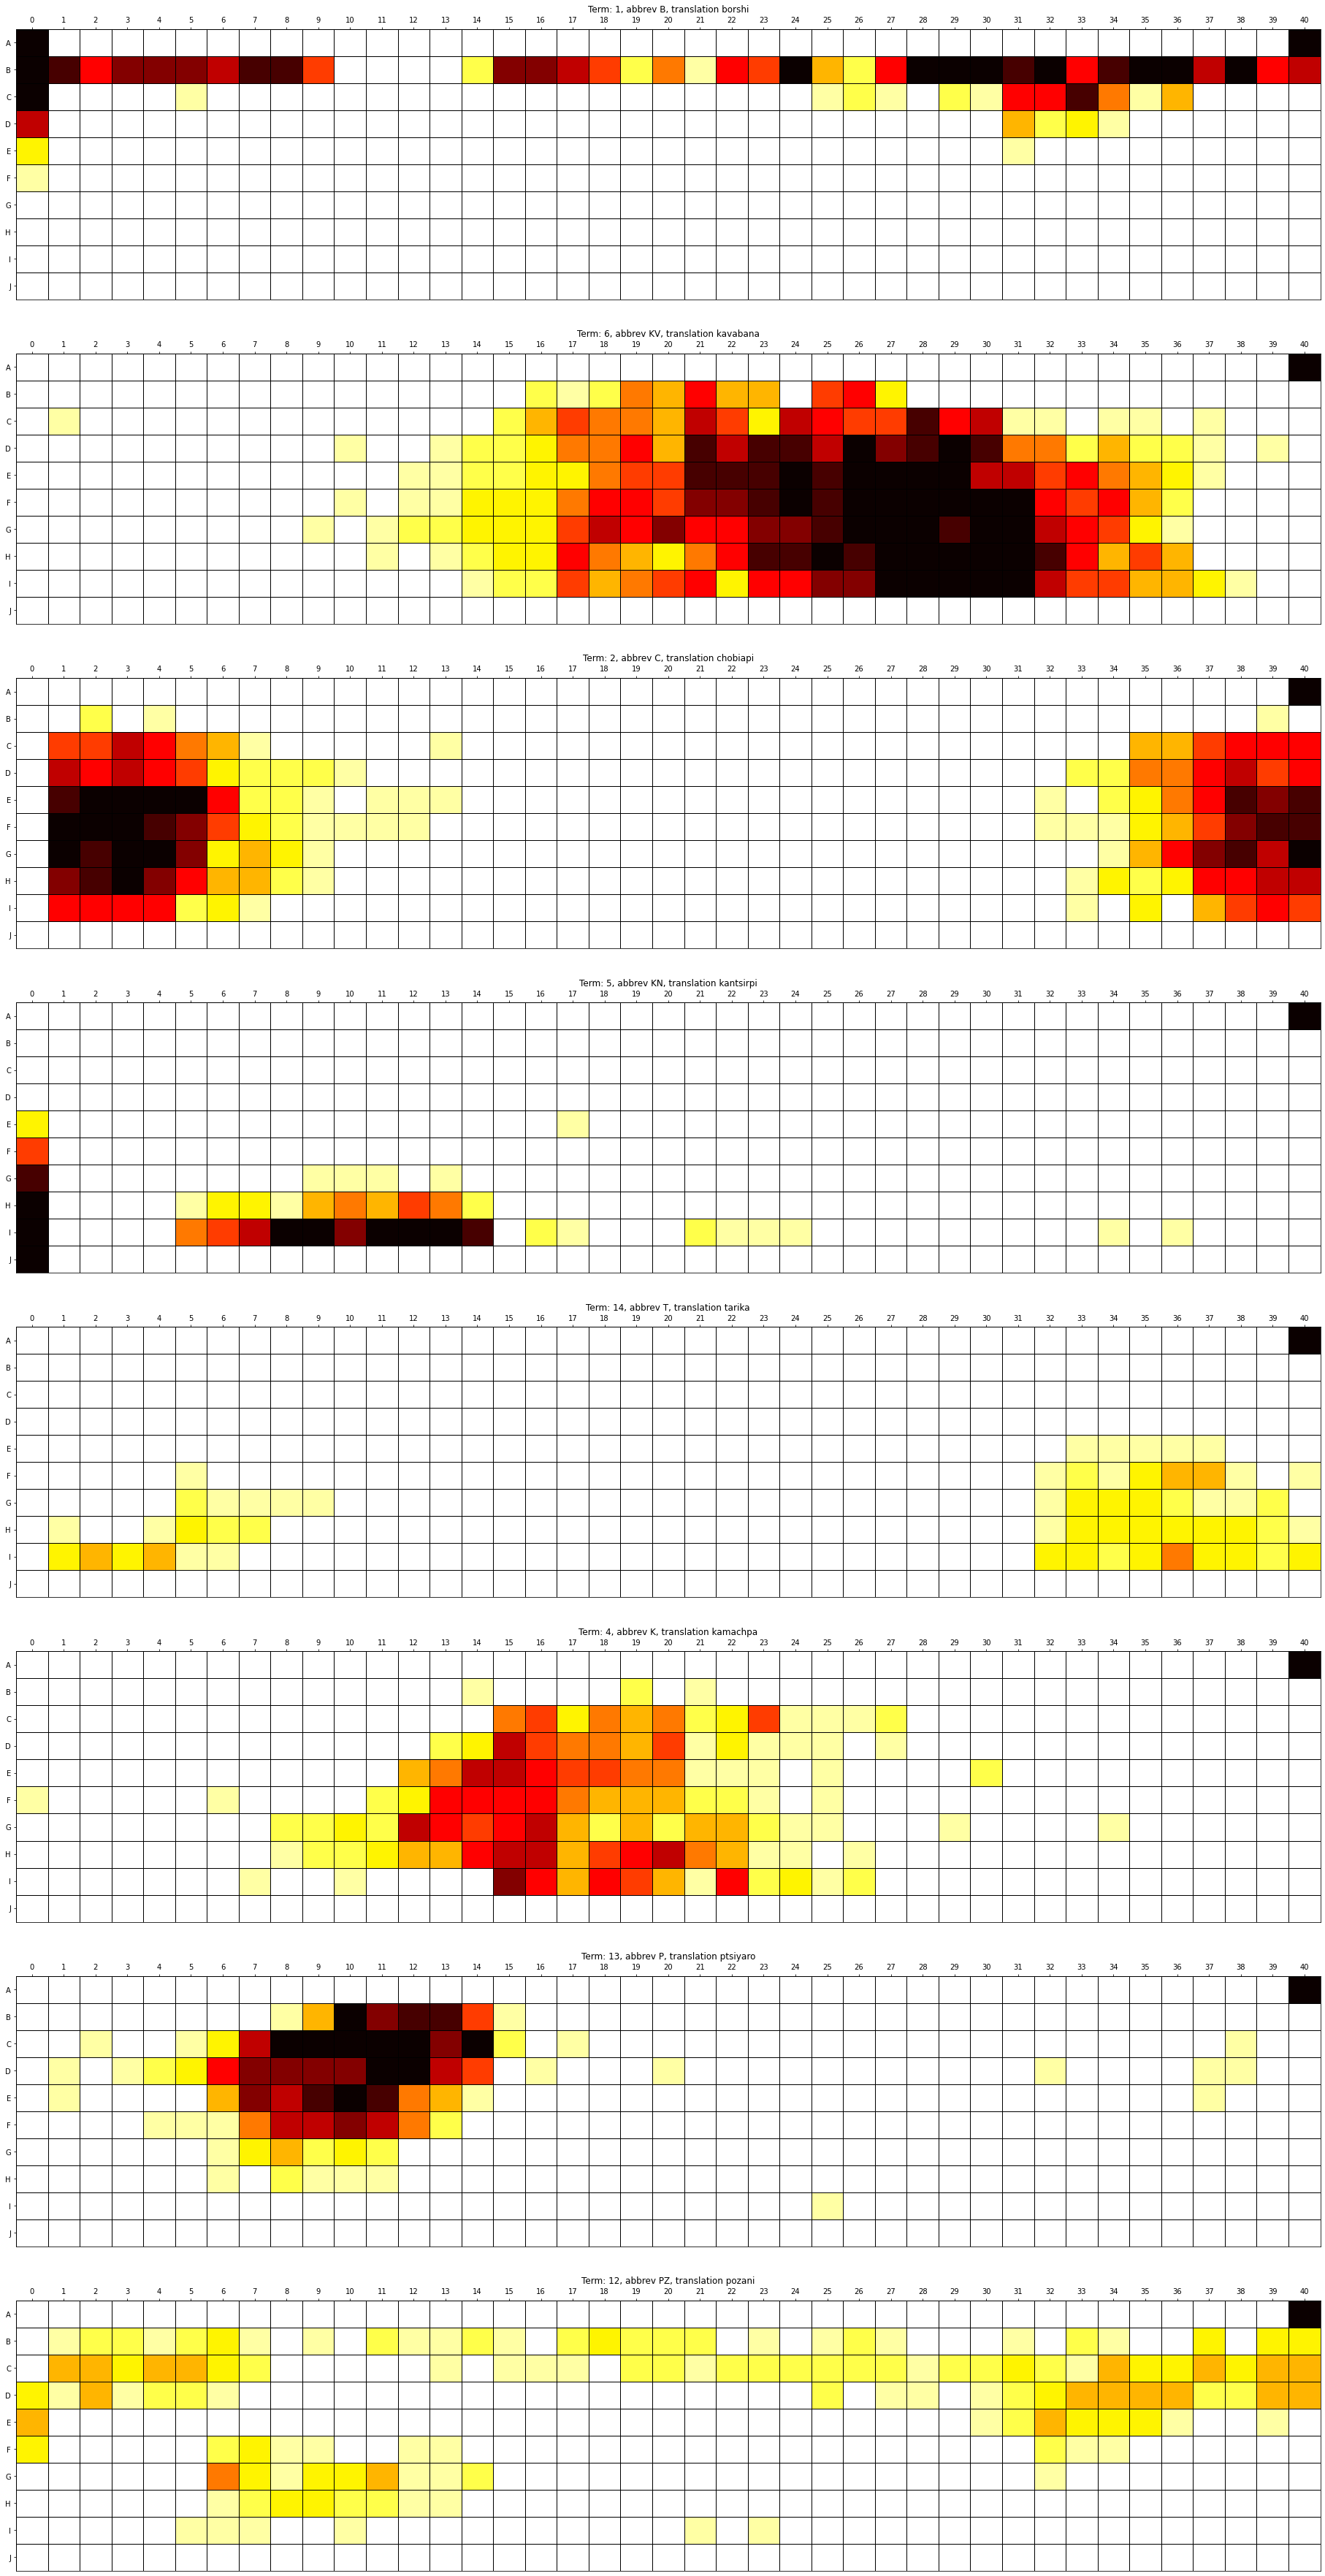

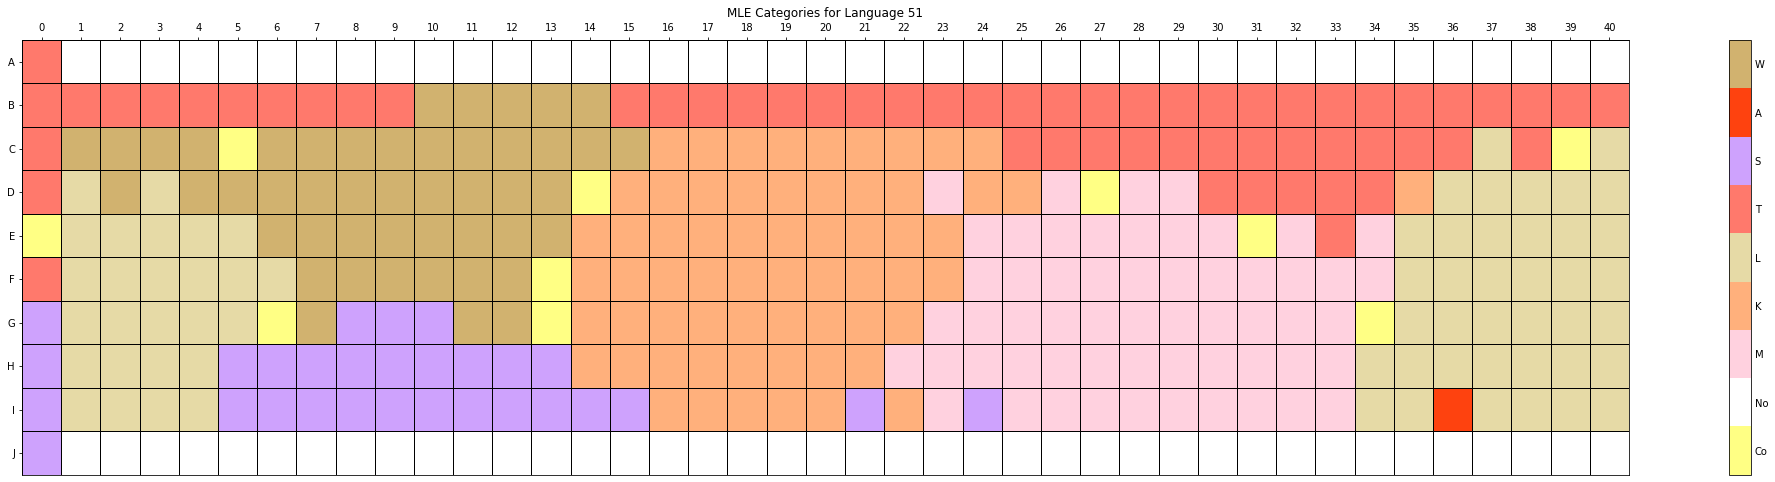

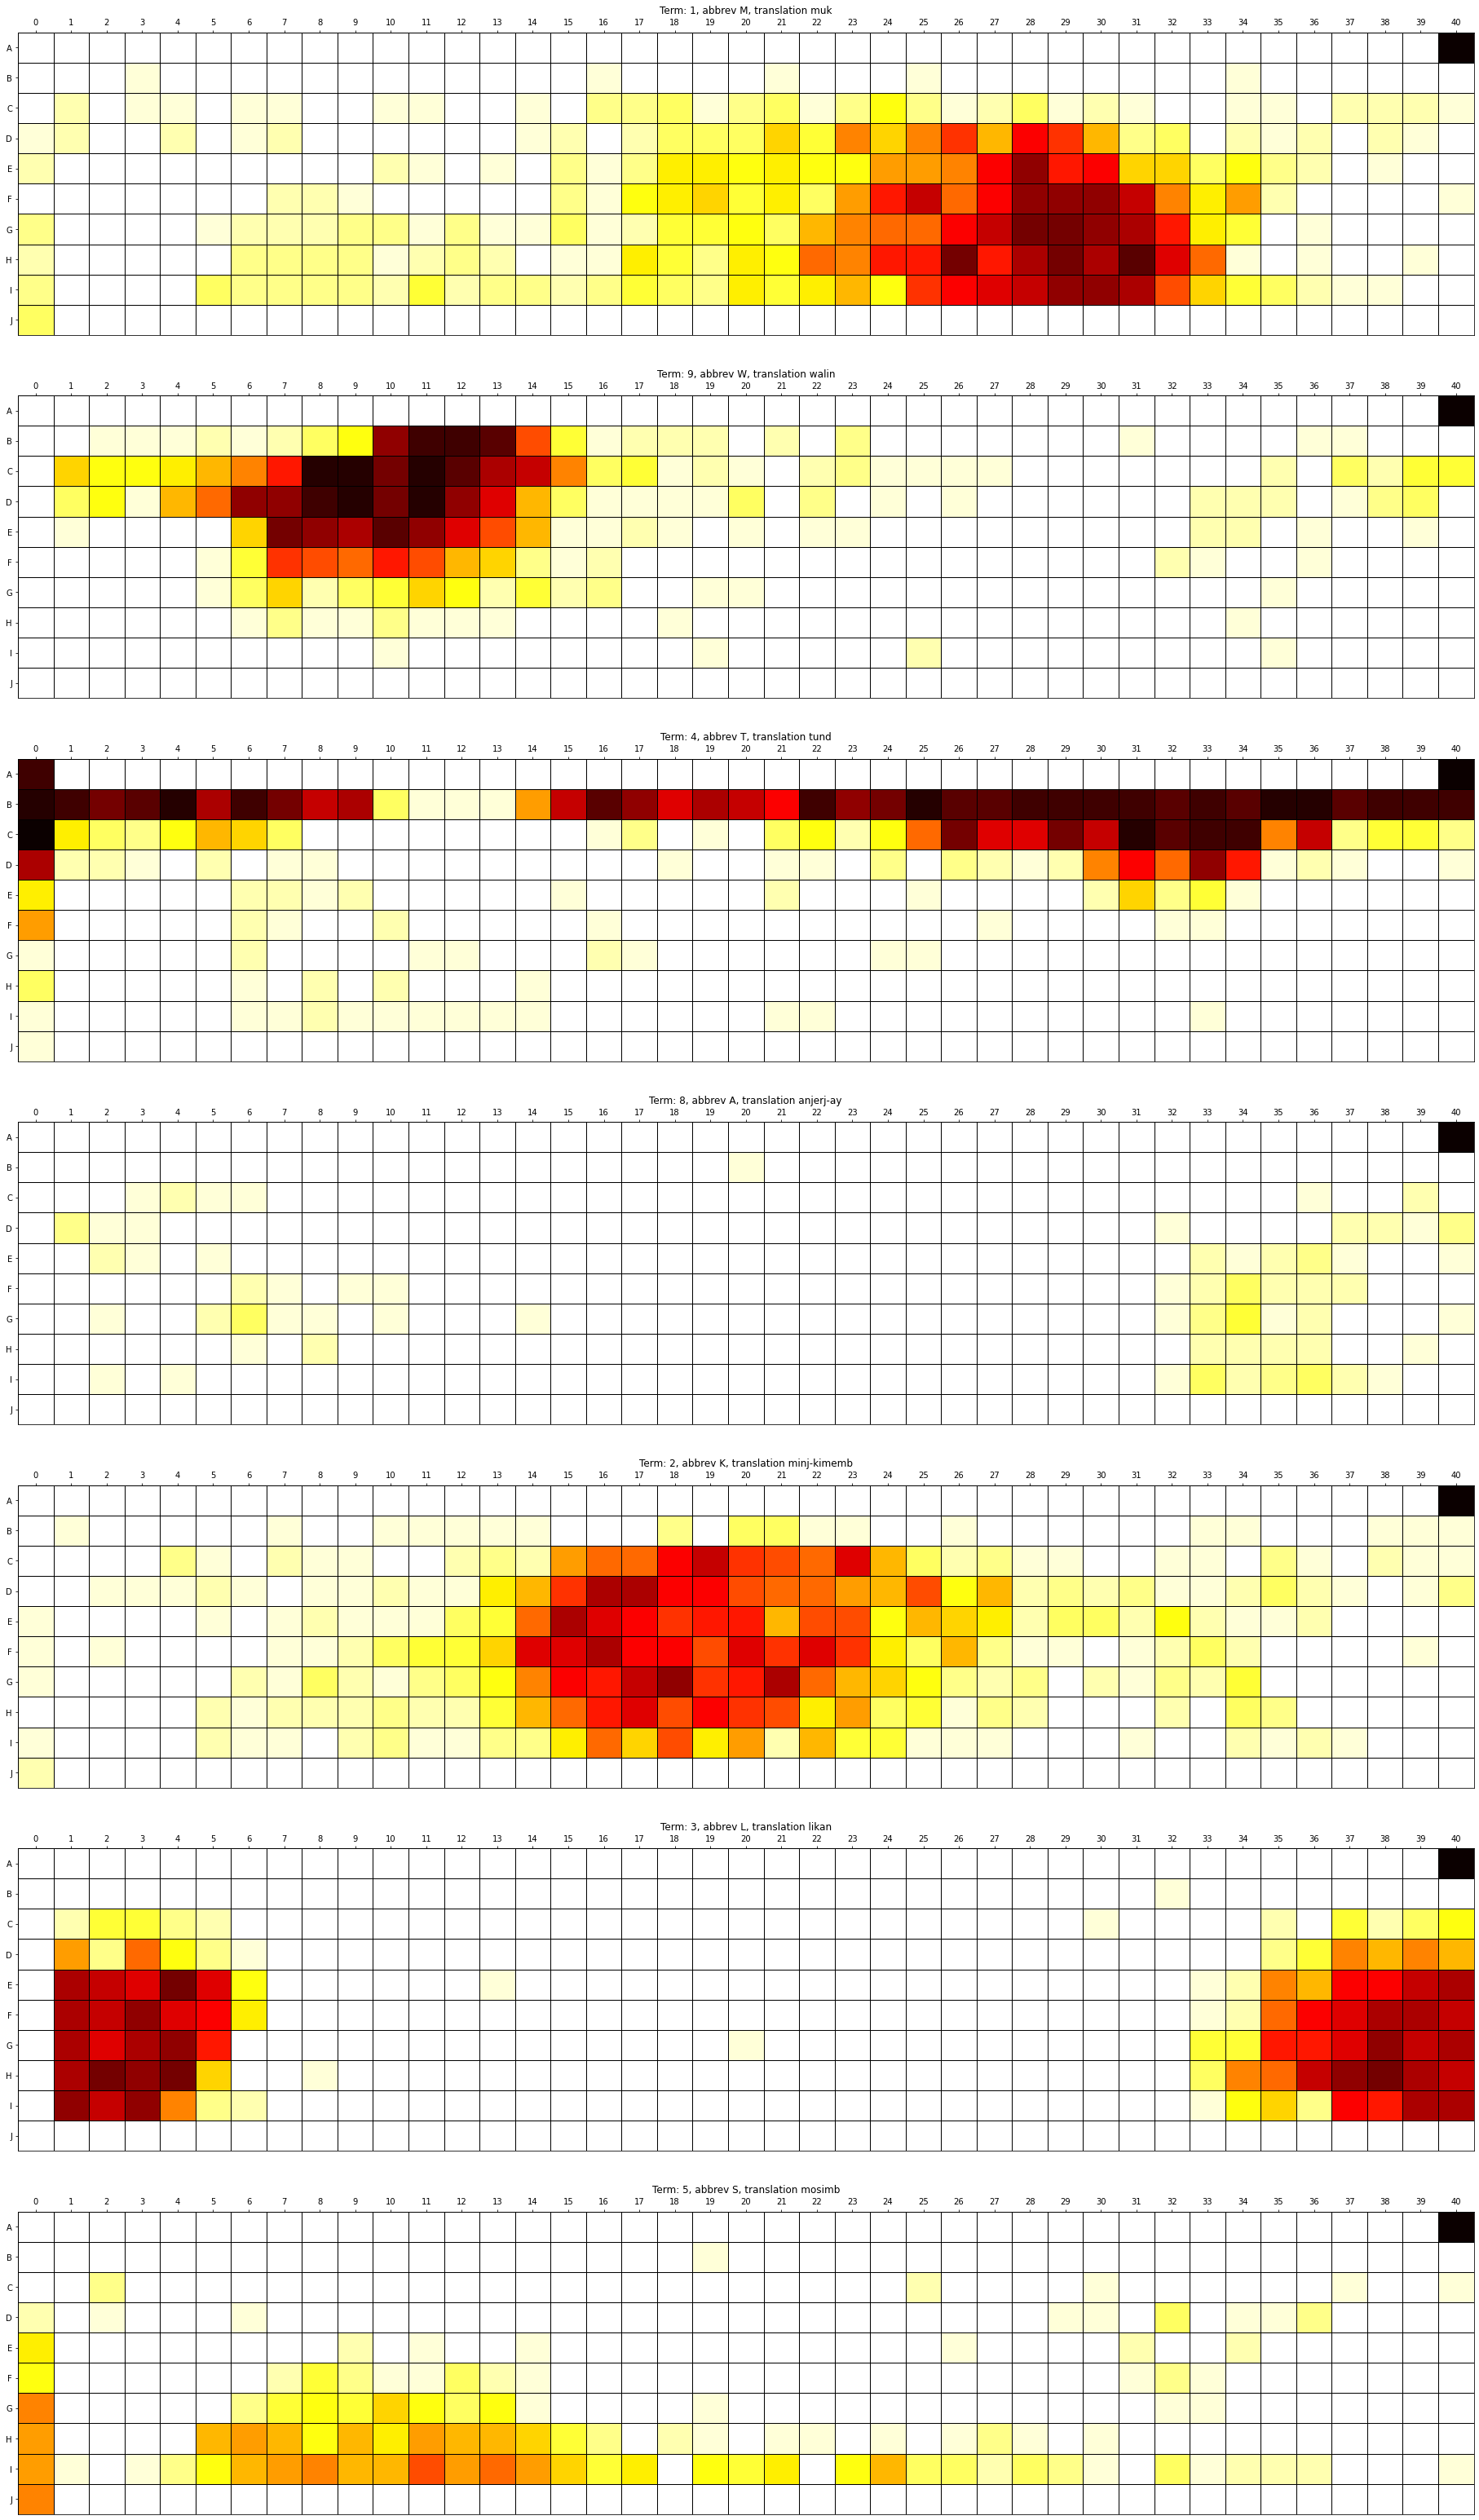

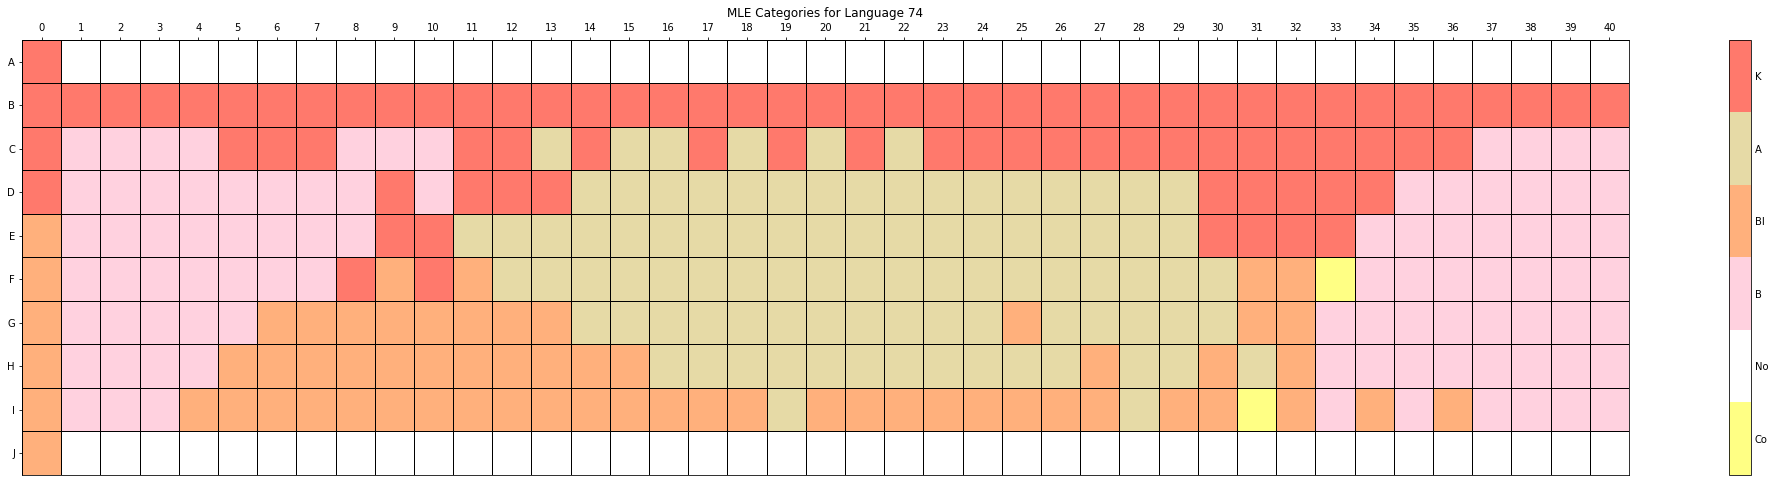

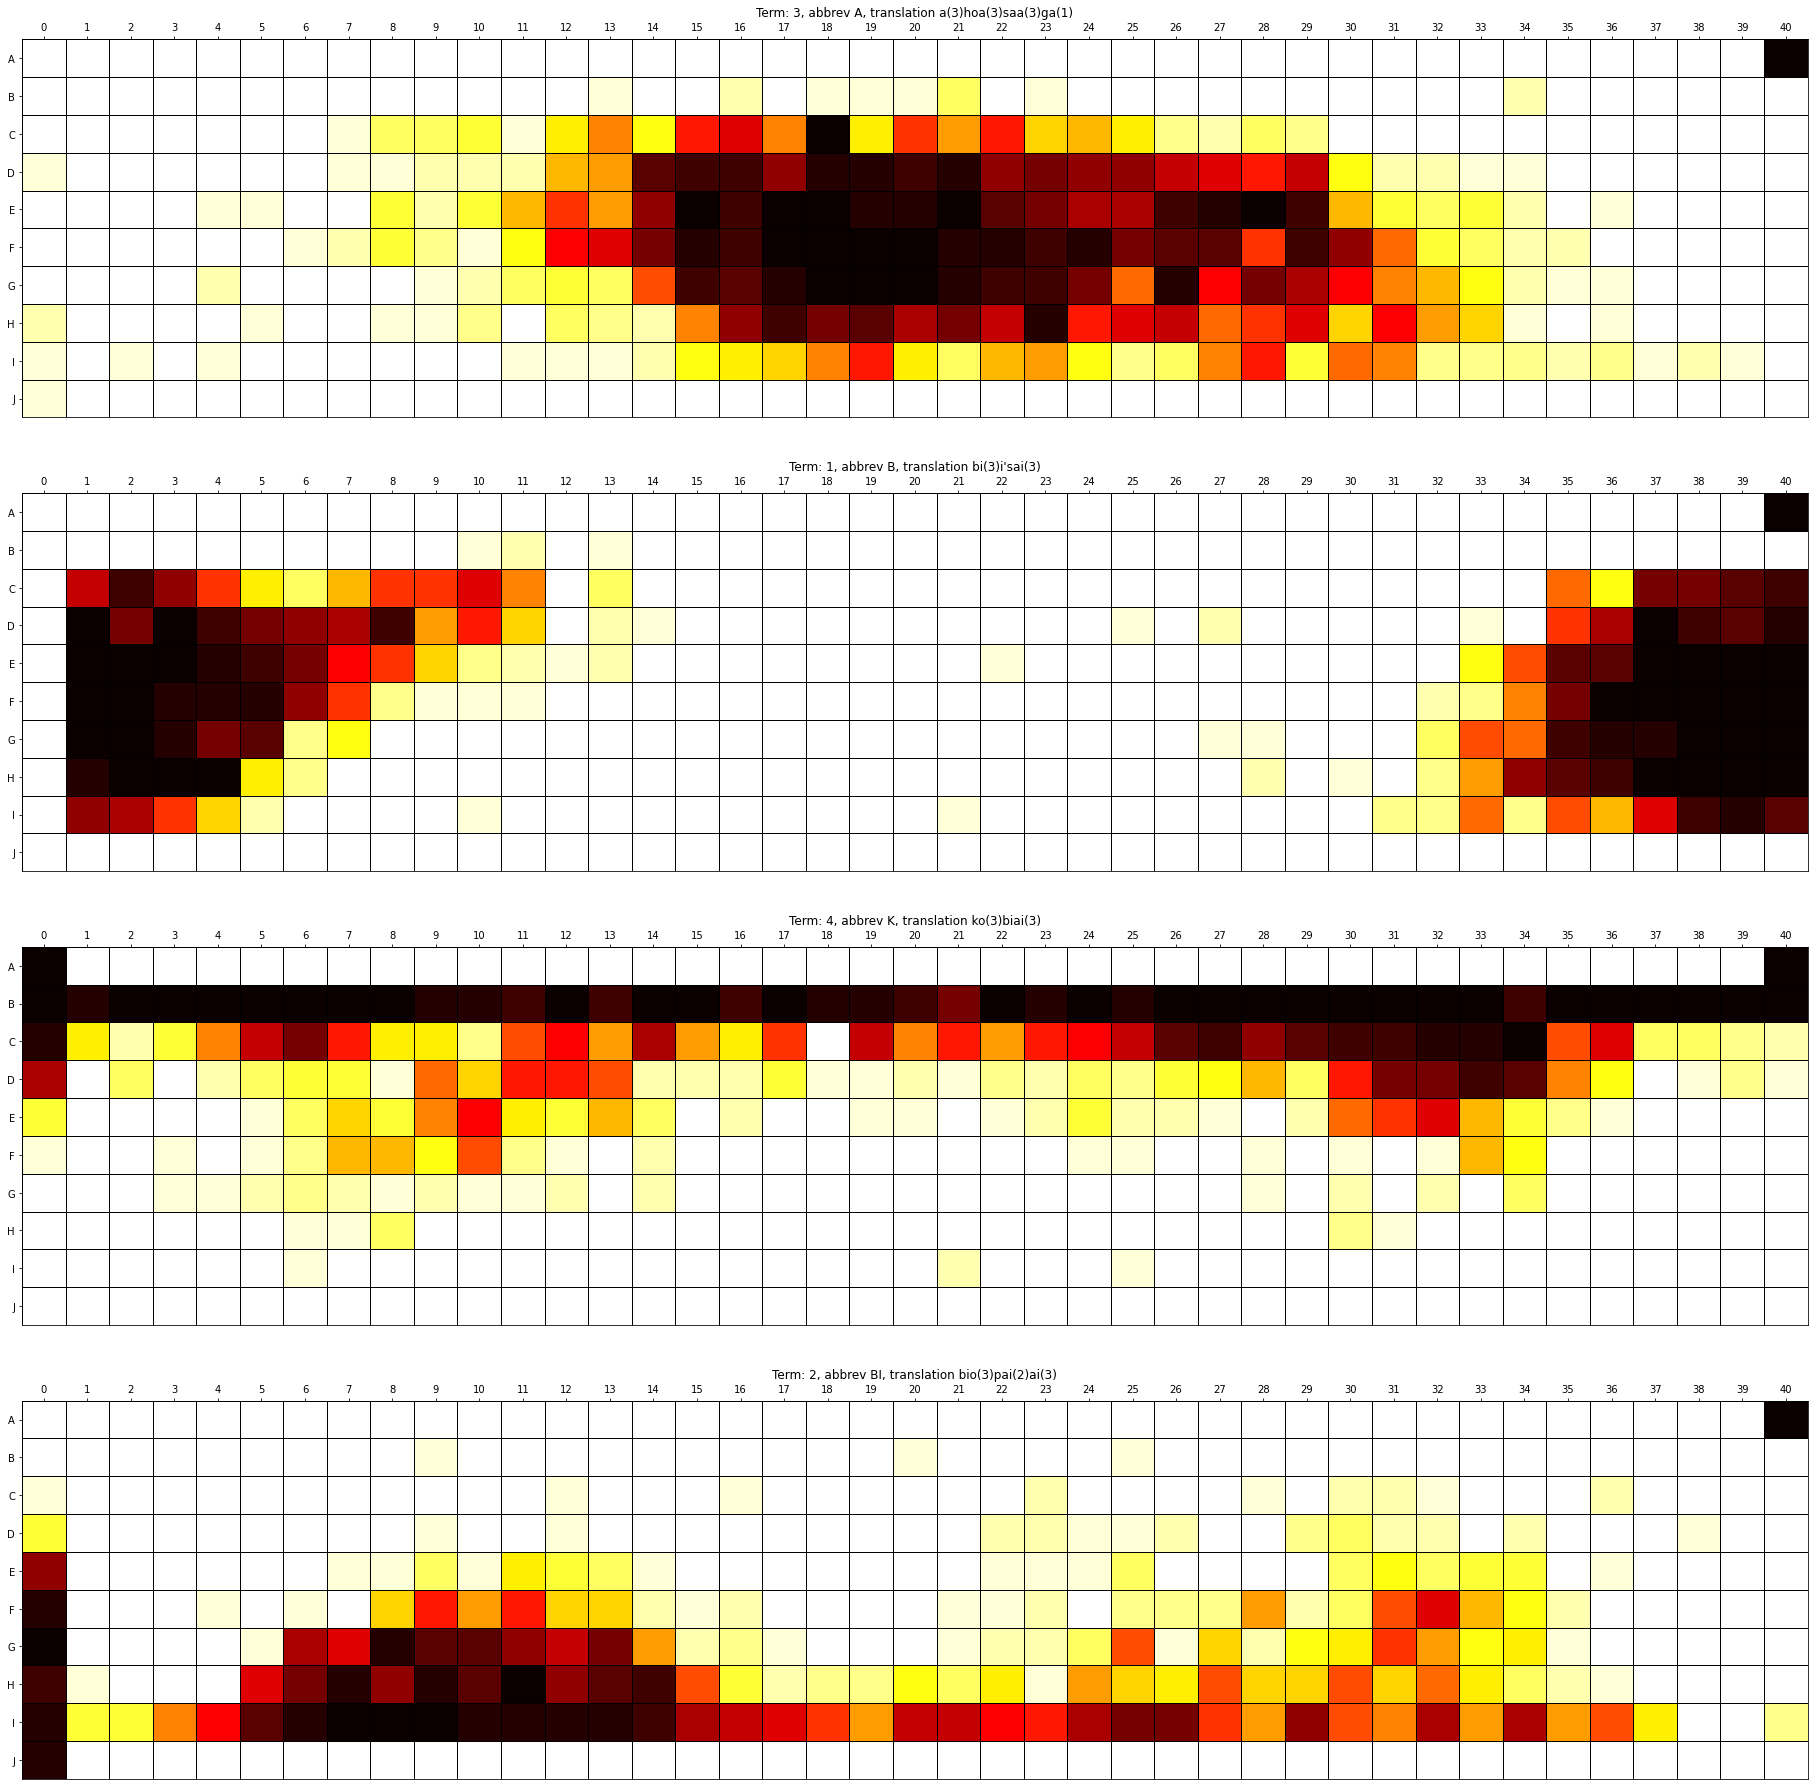

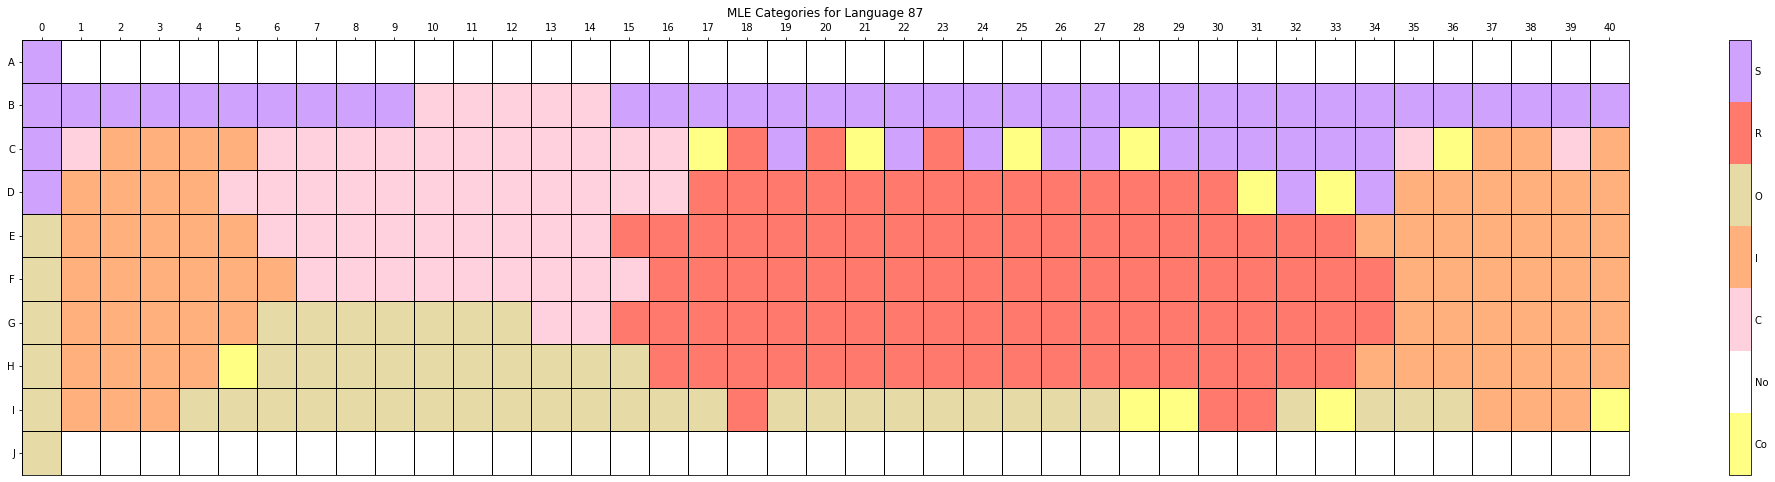

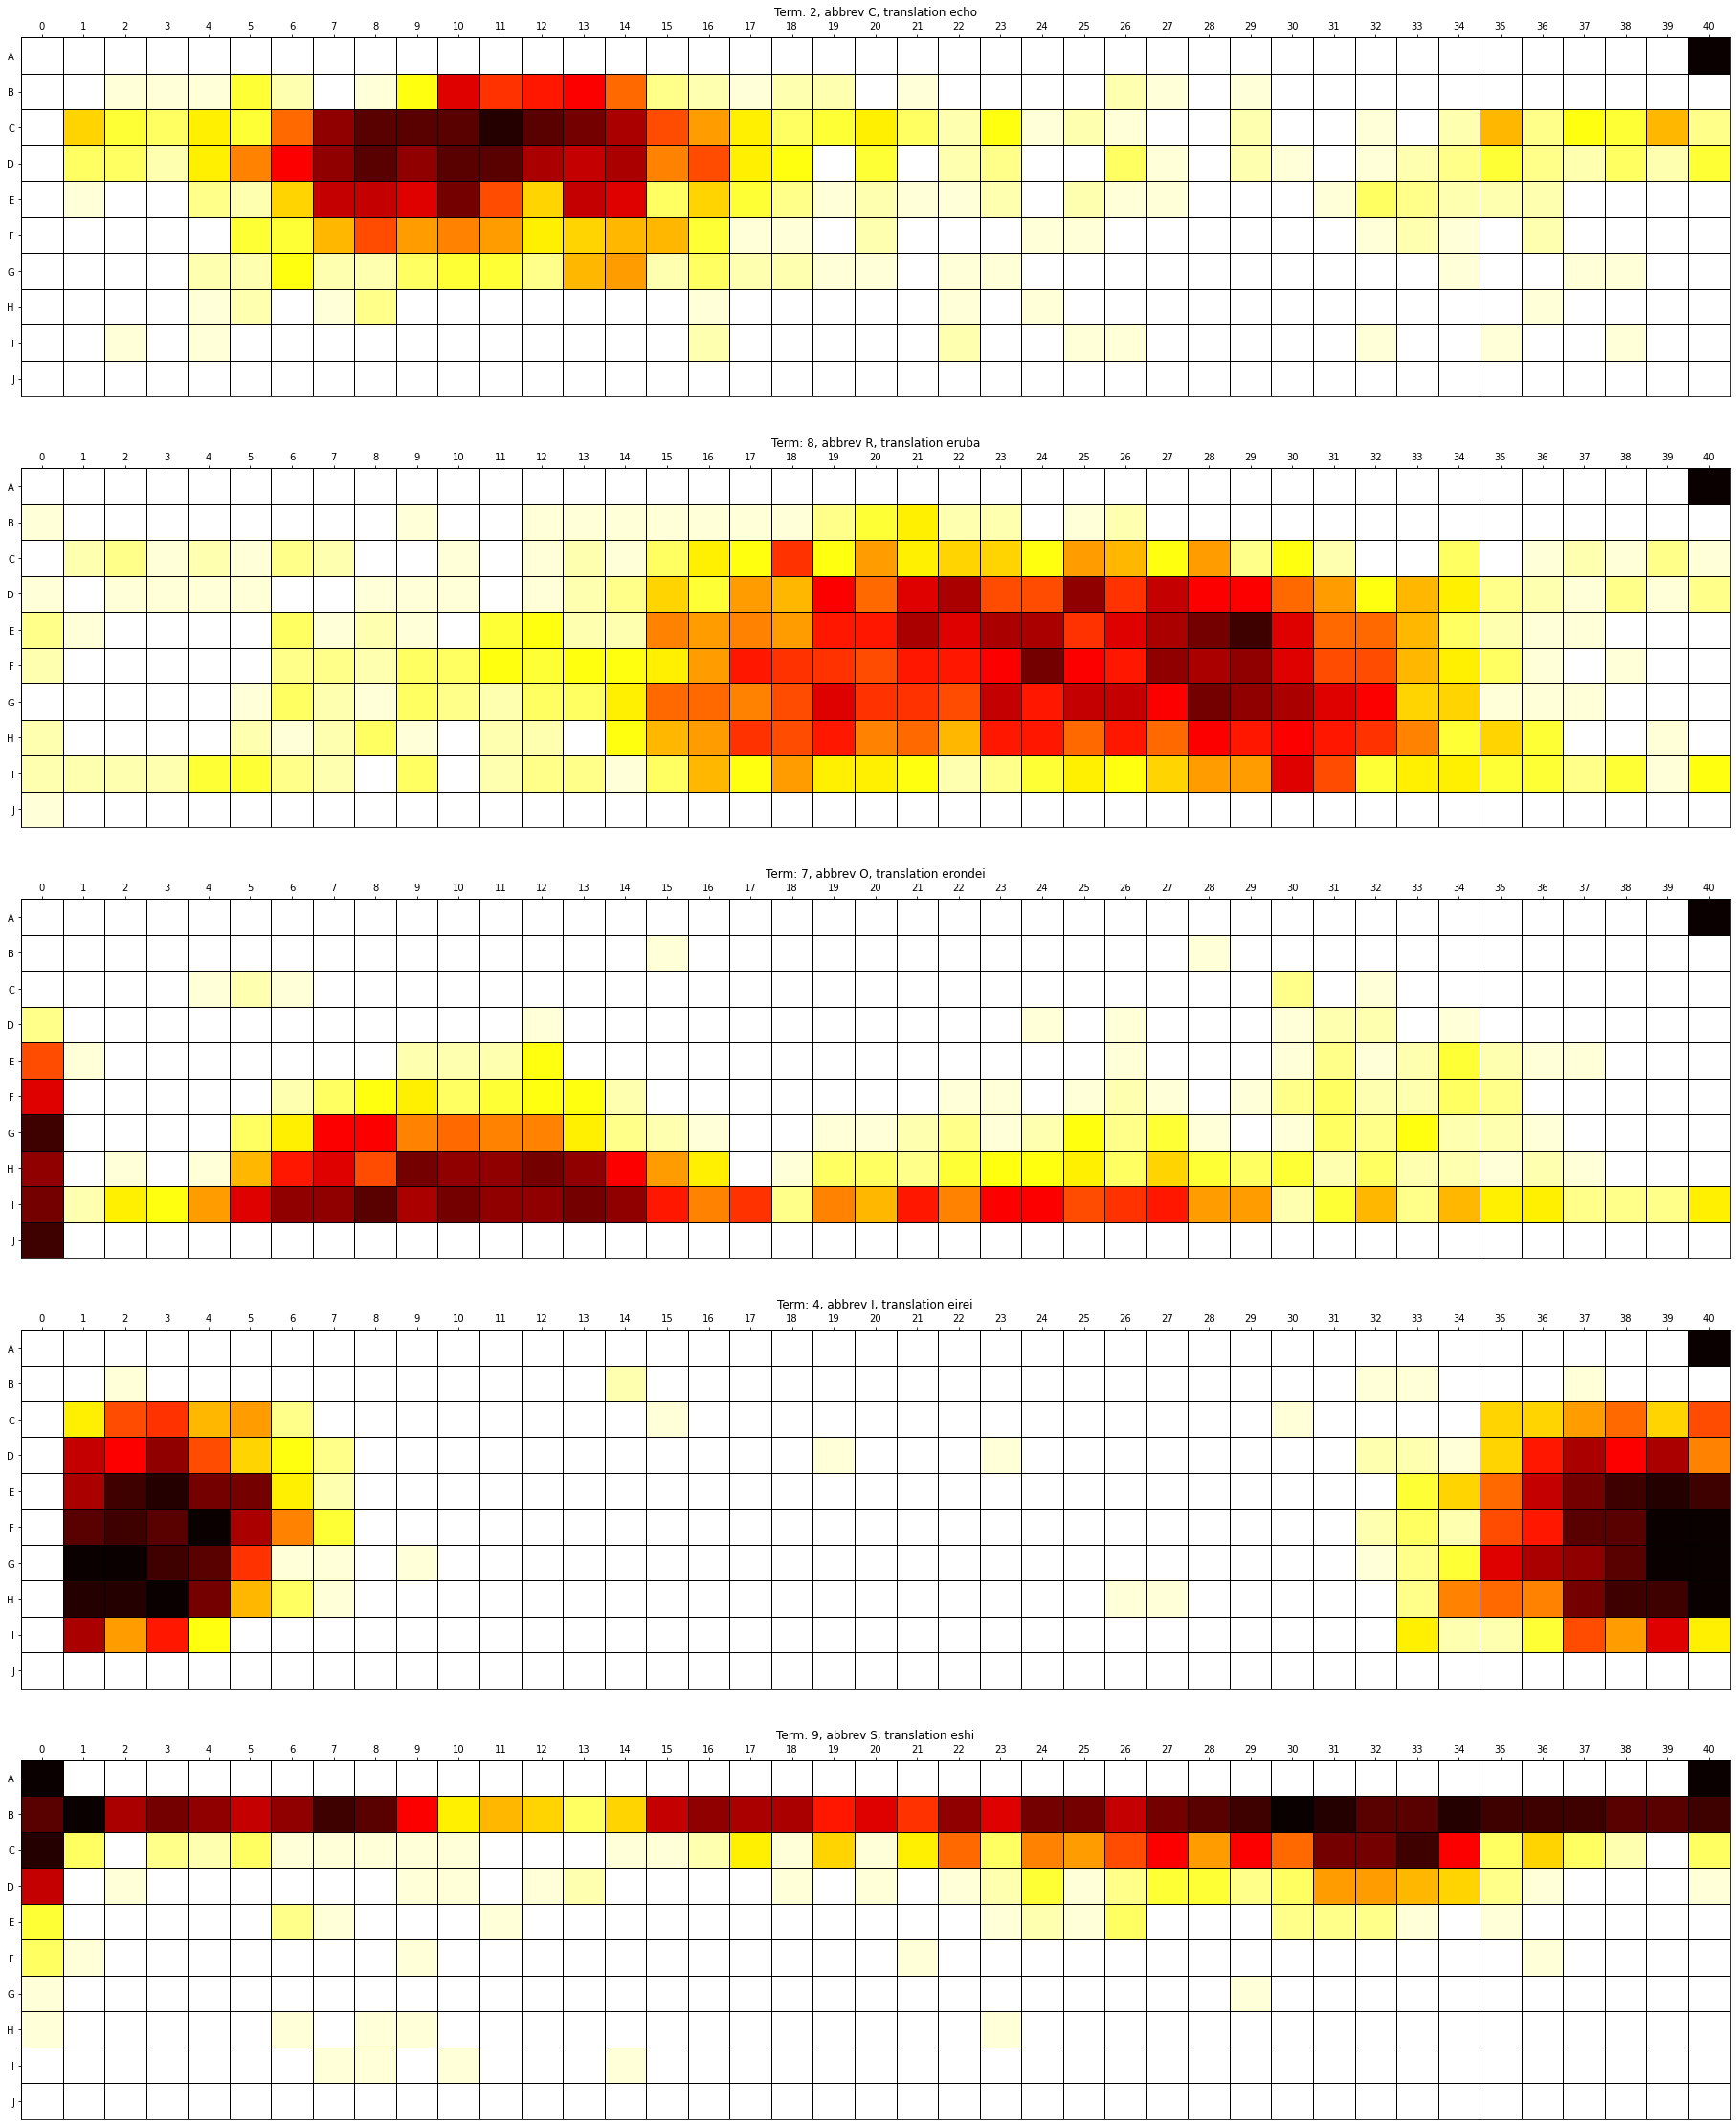

In [36]:
langs = [16, 17, 32, 36, 20, 51, 74, 87]
# langs = [17]
for lang in langs:
    print('Making grid and heatmaps for lang ', lang)
    mles, bcts, num_bcts = build_simple_mle(word_counts[lang], term_maps[lang])
    simple_mle_grid(mles, lang)
    bct_heatmaps(lang, word_counts[lang], bcts)
    

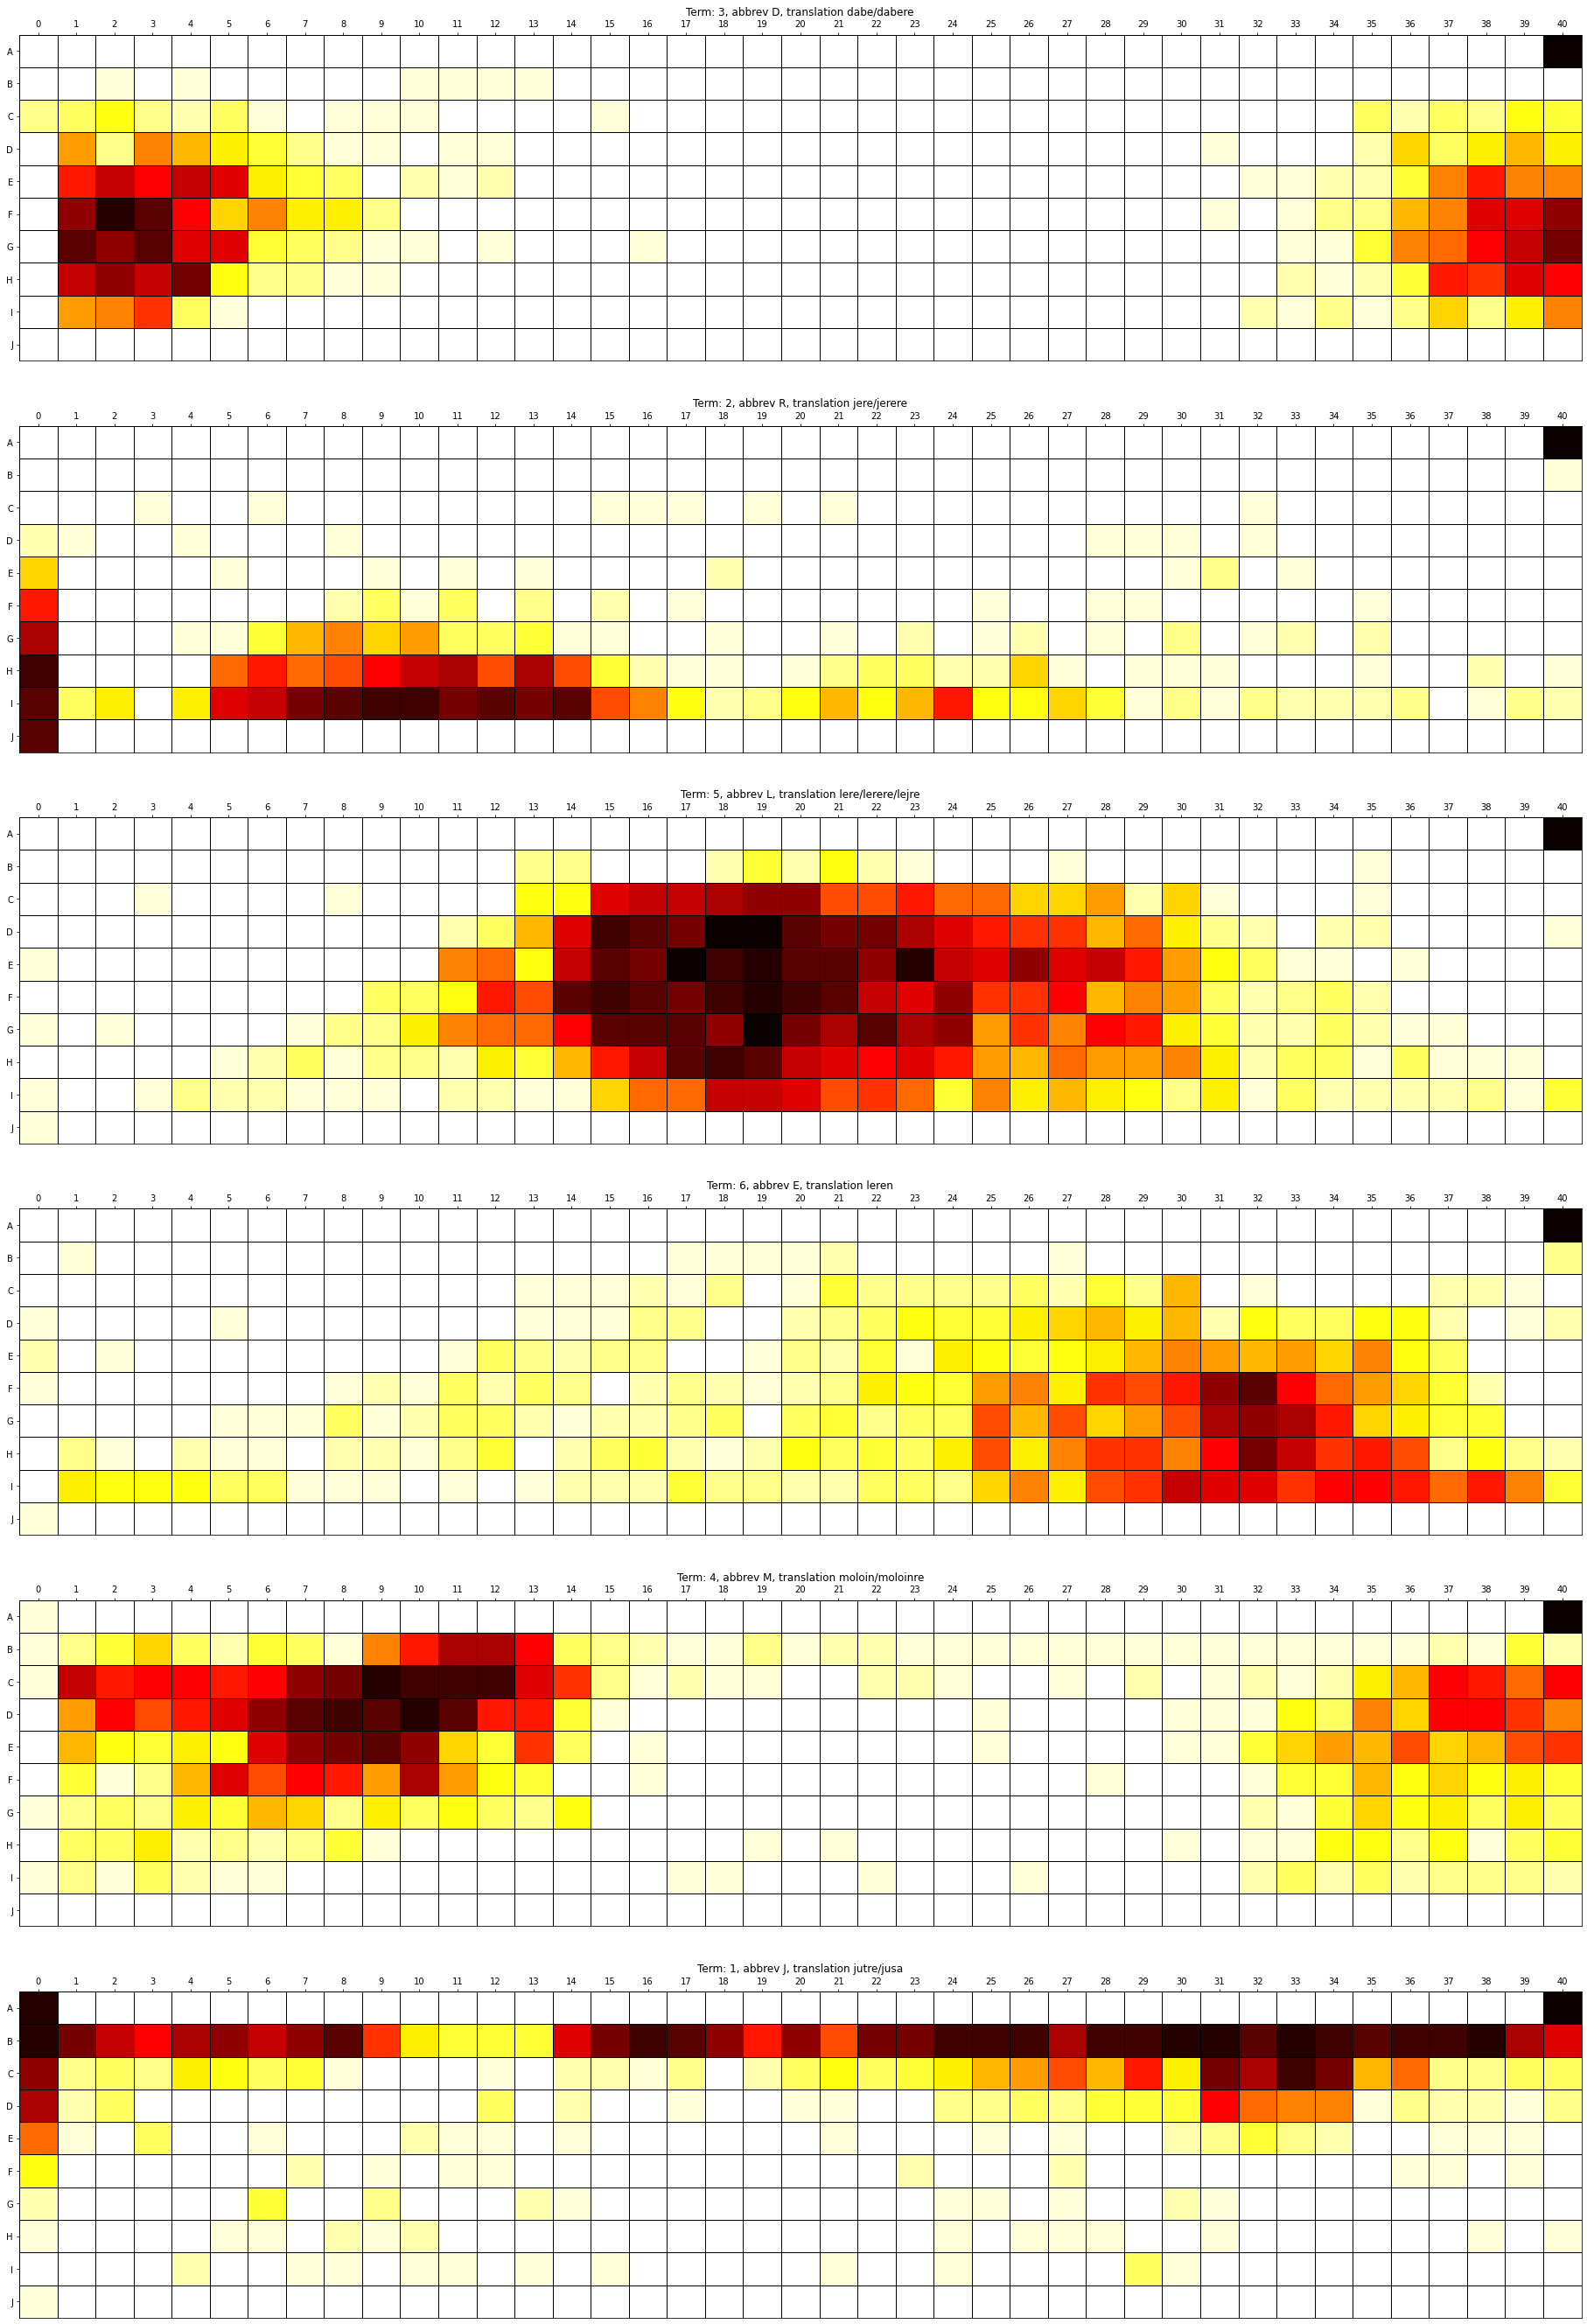

In [75]:
bct_heatmaps(lang, word_counts[lang], bcts)

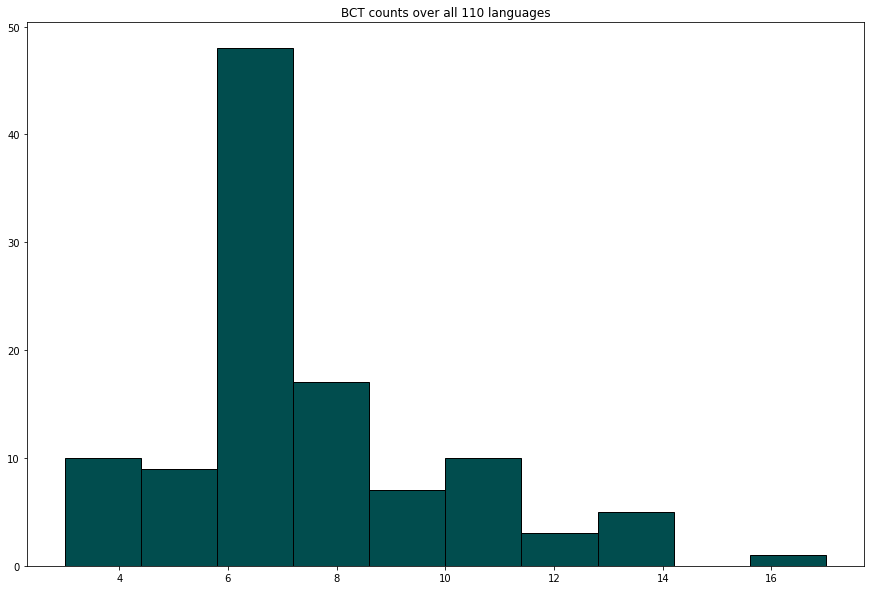

In [158]:
all_langs_num_BCTs(word_counts)